# Import module

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pandas_datareader as web
import talib
import seaborn as sns
import gym
from gym import spaces
from gym.utils import seeding
import enum
import pyfolio as pf

import matplotlib.pyplot as plt
import pickle
import os
import random
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

C:\Users\User\anaconda3\envs\MyDjango\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


# Stock Data

Stock name: DIS
Start: 2013-02-19 00:00:00, End: 2020-12-31 00:00:00
Training data: 1227 
Tsesting data: 756 


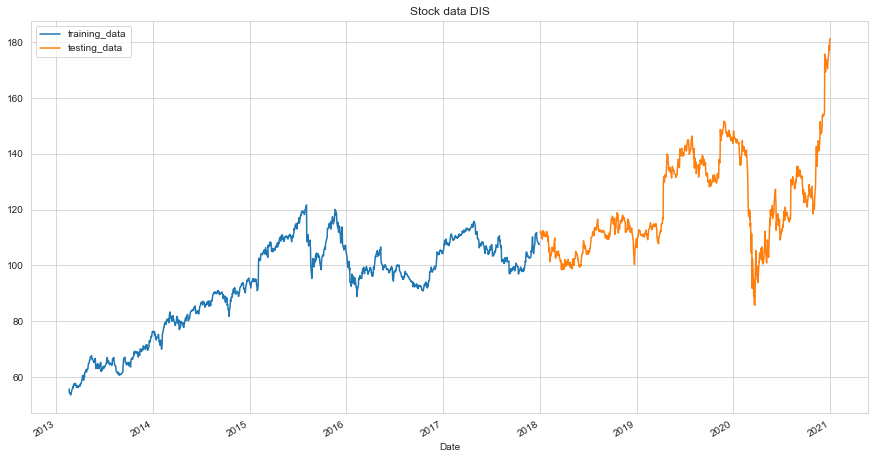

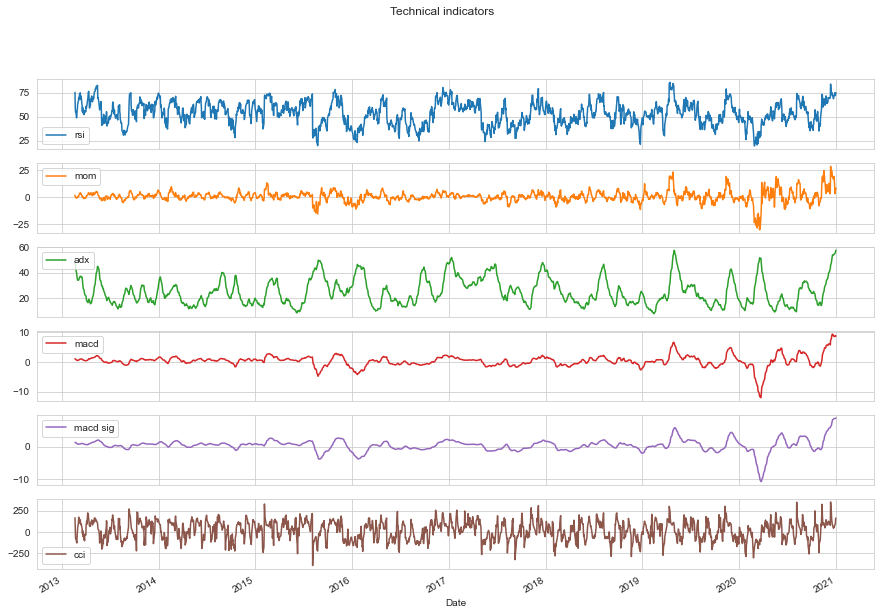

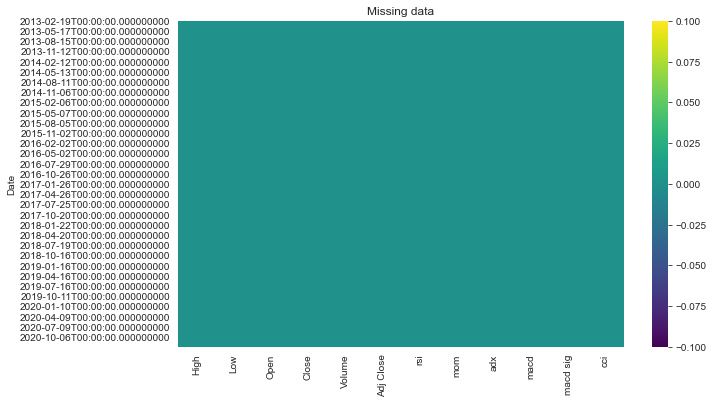

,High,Low,Open,Close,Volume,Adj Close,rsi,mom,adx,macd,macd sig,cci
Date,,,,,,,,,,,,
2013-02-19,55.950001,55.570000,55.580002,55.730000,7780500.0,55.730000,75.551953,1.829998,49.339223,1.183625,1.317280,167.036583
2013-02-20,55.820000,54.560001,55.619999,54.599998,8460700.0,54.599998,59.754665,0.309998,47.570780,1.076100,1.269044,47.082234
2013-02-21,54.820000,54.009998,54.580002,54.169998,6802500.0,54.169998,55.038609,-0.350002,45.135352,0.945292,1.204293,-72.297695
2013-02-22,54.580002,53.930000,54.389999,54.250000,7603600.0,54.250000,55.738530,-0.110001,42.762257,0.838417,1.131118,-78.152899
2013-02-25,54.790001,53.590000,54.599998,53.590000,9830200.0,53.590000,48.966256,-1.070000,40.084670,0.692478,1.043390,-119.793063


In [3]:
stock_name = 'dis'.upper()
stock_data = web.DataReader(stock_name, 'yahoo', '2013-01-01', '2021-01-01')
stock_data['Volume'] = stock_data['Volume'].apply(lambda vol: np.NaN if vol == 0 else vol)
stock_data['Adj Close'] = stock_data['Close']
stock_data['rsi'] = talib.RSI(stock_data['Adj Close'])
stock_data['mom'] = talib.MOM(stock_data['Adj Close'])
stock_data['adx'] = talib.ADX(stock_data['High'], stock_data['Low'], stock_data['Adj Close'])
stock_data['macd'], stock_data['macd sig'], _ = talib.MACD(stock_data['Adj Close'])
stock_data['cci'] = talib.CCI(stock_data['High'], stock_data['Low'], stock_data['Adj Close'])
stock_data.dropna(axis=0, inplace=True)

train_data = stock_data.loc[:'2018-01-01']
test_data = stock_data.loc['2018-01-01':]


print(f'Stock name: {stock_name}')
print(f'Start: {stock_data.index[0]}, End: {stock_data.index[-1]}')
print(f'Training data: {len(train_data)} ')
print(f'Tsesting data: {len(test_data)} ')

sns.set_style('whitegrid')
train_data['Adj Close'].plot(label='training_data', figsize=(15,8));
test_data['Adj Close'].plot(label='testing_data');
plt.title('Stock data '+ stock_name)
plt.legend();
plt.show()

stock_data[['rsi', 'mom', 'adx', 'macd', 'macd sig', 'cci']].plot(subplots=True, figsize=(15,10), title='Technical indicators');
plt.show()


plt.figure(figsize=(10,6))
sns.heatmap(stock_data.isnull(), cmap='viridis');
plt.title('Missing data');
plt.show()
high = stock_data['Adj Close'].max()

stock_data.head()

# Agent

In [13]:
     

class QAgent(object):
    
    
    def __init__(self, state_size, action_size, gamma=0.9, ticker=''):
        
        
        self.state_size = state_size
        self.action_size = action_size
        self.model = self.build_model_nn()
        self.gamma = gamma  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.ticker = ticker
        self.save_epsilon = []
    
    
    
    def seeding(self, seeds=101):
        return np.random.seed(seeds)
    
    
    
    def build_model_nn(self):
        
        class LinearModel:
            
            def __init__(self, input_dim, n_action):
                
                self.W = np.random.randn(input_dim, n_action) / np.sqrt(input_dim)
                self.b = np.zeros(n_action)
                self.vW = 0
                self.vb = 0
                self.losses = []
                

            def forward(self, s):
                return s.dot(self.W) + self.b
            

            def sgd(self, s, Y, learning_rate=0.01, momentum=0.9):
                num_values = np.prod(Y.shape)

                Y_hat = self.forward(s)  # shape (1, 8)
                gW = 2 * s.T.dot(Y_hat - Y) / num_values  # vector shape (7, 8)
                gb = 2 * (Y_hat - Y).sum(axis=0) / num_values  # scalar

                self.vW = momentum * self.vW - learning_rate * gW  # vector shape (7, 8)
                self.vb = momentum * self.vb - learning_rate * gb  # scalar

                self.W += self.vW  # vector shape (7, 8)
                self.b += self.vb  # scalar
                
                

                mse = np.mean((Y_hat - Y) ** 2)
                print(mse)
                self.losses.append(mse)
        
        
        self.seeding()
        model = LinearModel(self.state_size, self.action_size)
        
        return model
    

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        act_values = self.model.forward(state)
        return np.argmax(act_values[0])  # returns action


    def train(self, state, action, reward, next_state, done):
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.amax(self.model.forward(next_state), axis=1)

        target_full = self.model.forward(state)
        target_full[0, action] = target

        # Run one training step
        self.model.sgd(state, target_full)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        self.save_epsilon.append(self.epsilon)
        

    def load(self):
   
        npz = np.load(f'state_dict/{self.ticker}.npz')
        self.model.W = npz['W']
        self.model.b = npz['b']
        print('Loading complete!!')
        


    def save(self):
        
        np.savez(f'state_dict/{self.ticker}.npz', W=self.model.W, b=self.model.b)
        
        print('Save!!')

# Environment

In [14]:
# environment

class SingleStock:
    def __init__(self, data, capital):
        self.stock_price_history = data
        self.n_step = self.stock_price_history.shape[0]
        self.capital = capital
        self.current_step = None
        self.stock_owned = None
        self.stock_price = None
        self.cash_in_hand = None
        self.state_dim = 8 #[stock price, stock_owned, cash__in_hand, rsi, mom, adx, macd, macd_sig]
        self.save_position = []
        self.save_port_val = [] 
        self.save_cash = []
        self.stock_value = []
        self.action_space = [0,1]
        self.sell_buy = None
        self.save_stock_price = []
        self.rsi = None
        self.mom = None
        self.adx = None
        self.macd = None
        self.masc_sig = None
        self.save_reward = None
        self.reset()
        
        
    def state_vector(self):
        vector = np.empty(self.state_dim)
        vector[0] = self.stock_price
        vector[1] = self.stock_owned
        vector[2] = self.cash_in_hand
        vector[3] = self.rsi
        vector[4] = self.mom
        vector[5] = self.adx
        vector[6] = self.macd
        vector[7] = self.masc_sig
        return vector
    
    
    def reset(self):
        self.current_step = 0
        self.stock_owned = 0
        self.stock_price = self.stock_price_history['Adj Close'][self.current_step]
        self.cash_in_hand = self.capital
        self.save_position = [0]
        self.save_port_val = [self.capital] 
        self.save_cash = [self.capital]
        self.stock_value = [0]
        self.sell_buy = []
        self.save_stock_price = [self.stock_price]
        self.rsi = self.stock_price_history['rsi'][self.current_step]
        self.mom = self.stock_price_history['mom'][self.current_step]
        self.adx = self.stock_price_history['adx'][self.current_step]
        self.macd = self.stock_price_history['macd'][self.current_step]
        self.masc_sig = self.stock_price_history['macd sig'][self.current_step]
        self.save_reward = [0]
        return self.state_vector()
    
    
    def port_val(self):
        return (self.stock_owned * self.stock_price) + self.cash_in_hand

    
    def cal_position(self):
        high = self.stock_price_history['Adj Close'].max()
        mid_price =  high/ 2
        max_pos = self.capital / mid_price
        slope = max_pos/-high
        c = -slope * high
        
        return slope * self.stock_price + c, high, max_pos
            

        
    def trade(self, action):
        '''
        action 0 = hold
        action 1 = sell
        action 2 = buy
        '''
        assert action in self.action_space
        
        action_vec = self.action_space[action]

        
        if action == 1:
            position_sh, high, max_pos = self.cal_position()
            diff = position_sh - self.stock_owned
            if diff < 0:
                #sell
                self.stock_owned = position_sh
                self.cash_in_hand += abs(diff) * self.stock_price
                self.sell_buy.append('sell')
                
                
            elif diff > 0:
                #buy
                self.stock_owned = position_sh
                self.cash_in_hand -= abs(diff) * self.stock_price
                self.sell_buy.append('buy')
                
        self.save_cash.append(self.cash_in_hand)
        self.save_port_val.append(self.port_val())
        self.save_position.append(self.stock_owned)
        self.stock_value.append(self.stock_owned * self.stock_price)
        self.save_stock_price.append(self.stock_price)
        
             
    def step(self, action):
        assert action in self.action_space
        
        prev_val = self.port_val()
        self.current_step += 1
        self.stock_price = self.stock_price_history['Adj Close'][self.current_step]
        self.rsi = self.stock_price_history['rsi'][self.current_step]
        self.mom = self.stock_price_history['mom'][self.current_step]
        self.adx = self.stock_price_history['adx'][self.current_step]
        self.macd = self.stock_price_history['macd'][self.current_step]
        self.masc_sig = self.stock_price_history['macd sig'][self.current_step]
        self.trade(action)
        current_val = self.port_val()
        reward = current_val - prev_val
        self.save_reward.append(reward)
        done = self.current_step == self.n_step - 1
        info = {'stock_price': self.save_stock_price,
                'portfolio_value': self.save_port_val,
                'current_val': self.save_reward,
                'stock_owned': self.save_position,
                'cash_in_hand': self.save_cash,
                'stock_value': self.stock_value,
               }
        return self.state_vector(), reward, done, info

# Config

In [15]:
num_episodes = 2000

capital = 1000
train_env = SingleStockEnv(data=train_data,
                           capital=capital)
state_size = train_env.state_dim
nb_action = 2
agent = QAgent(state_size,
               nb_action,
               gamma=0.9,
               ticker=stock_name)
scaler = train_env.get_scaler()


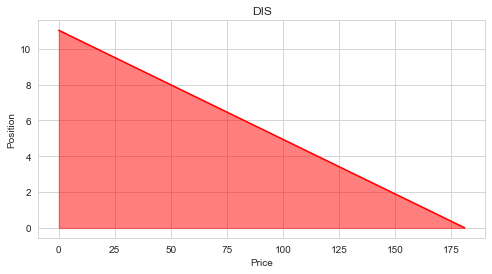

In [16]:
x = np.arange(high)
y = train_env.slope * x + train_env.c

plt.figure(figsize=(8,4))
plt.plot(x,y, 'r');
plt.fill_between(x, y, 0, alpha=0.5, color='r');
plt.xlabel('Price');
plt.ylabel('Position');
plt.title(stock_name);

# Training

In [17]:
print('Training Model')
cashflow = []
total_reward = []

with open(f'scaler/{stock_name}.pkl', 'wb') as f:
    pickle.dump(scaler, f)

for e in tqdm(range(num_episodes)):
    
    state = train_env.reset()
    state = scaler.transform([state])
    done = False
    step_reward = 0
    history_reward = []
    

    while not done:
        action = agent.act(state)
        next_state, last_reward, done, info = train_env.step(action)
        next_state = scaler.transform([next_state])
        agent.train(state, action, last_reward, next_state, done)
        step_reward += last_reward
        state = next_state
        history_reward.append(last_reward)
        
    total_reward.append(step_reward)
        
    
    if (e+1) % (num_episodes/20) == 0 or (e+1 == 1):     
        print(f"Episode: {e + 1:4}/{num_episodes}")
        print(f"Begin portfolio value: {capital:8.2f}")
        print(f"End portfolio value: {info['portfolio_value'][-1]:10.2f}")
        print(f'Since: {len(train_data)} days')
        print(f"Return {(info['portfolio_value'][-1] - capital) * 100/capital:.2f} %")
        print(f"Epsilon: {agent.epsilon:2.5f}")
        print(f"Sell: {train_env.sell_buy.count('sell')}, Buy: {train_env.sell_buy.count('buy')}")
        print(f'Cumulative Reward: {sum(total_reward):8.2f}')
        print(f"Mean Squared Error Loss: {agent.model.losses[-1]:8.4f}")
        print('=======================================================================')
        print()
    
    cashflow.append(info['cashflow'][-1]) 



agent.save()
losses = agent.model.losses

print(f'average reward: {np.mean(cashflow):.2f}, min: {np.min(cashflow):.2f}, max: {np.max(cashflow):.2f}')
plt.figure(figsize=(12,6))
sns.histplot(cashflow, bins=50, color='r', kde=True);
plt.xlabel('cashflow');
plt.ylabel('Count');


Training Model


  0%|          | 0/2000 [00:00<?, ?it/s]

0.3405854872138831
0.03961254699506798
121700.08565045748
3650.1588199165553
12182.523531715064
0.0034590063598835758
27206.019743159468
0.002250611112326544
25122.61192819476
0.020982063564009983
0.016079593716396563
0.040004955675754045
1577.0775628318643
50.057596112693695
1435.8285178206334
2791.8832711876544
3284.808318837795
3045.5590371711146
1201.8548033336467
2000.5137095723496
92.33322823448609
556.4436469160153
256.1345958306884
7683.635183220751
146.216085953123
490.0299578750445
276.38023433593236
416.45757859737586
16091.192813590305
491.495026237992
262.7532967951038
7503.409001940243
4379.3795213057065
1142.0053942197005
18.67901752032527
366.2704857568896
3028.6801738688036
2403.5091552464346
1337.3720693473206
1232.881352118149
5240.438303268007
1410.0409030590288
199.13476840923445
298.797596004023
1667.6982143585192
3588.3997119738838
2113.2956576057504
1794.4040389398044
1104.1454786339389
593.5223930607152
0.7782813285182253
127.32813971551762
1402.159922538045
22

1.7788428776483454
0.6476719991773364
15.462215911906748
26.664842890447915
42.550489205384935
3.395709088623936
7.190205850221424
1.9396757505199118
5.513249017303763
1.193772910385273
1.3690860781931293
0.025308602157468038
0.02821195342411031
0.38661918969705383
0.3157663346497989
0.1574829544477602
0.05145823760241485
0.1319769950313748
0.17504930667949925
0.6017099210998327
0.03419136894858039
0.1630285054258315
3.0579185311019796
0.11535345561732356
7.938150559915977
0.696066729044436
0.2949254469573002
0.3177458953325385
1.4931105875968769
5.67164193049976
6.679989652131845
807.2900732124685
1.5179880309734575
22.220720461008657
4.246562130258383
8.777257712534864
3.490955480511982
13.432217446950872
3.5076111231637466
16.015710777993487
10.36287646561311
16.636915816206592
3.332786693586735
806.0709445084606
10.123236008331608
10.089973211263825
3.4704436983952003
1.9227522569795608
0.30191277165220615
3.641703780013812
1.4755859734766252
6.381204076190574
0.7696627823367365
16

5.975248665284939
5860.907011257207
52.363818731425205
182.59535496999337
964.1864596461498
4.579139082217373
0.7026970488902342
0.17247795170188712
4.694678926046869
0.4178658788996424
31.998664532666055
21.190151273396236
6.736685655968938
0.6521123718184664
19.510386851249272
8.160397468069823
17.714396330904652
35.62335534007418
27.318815315847104
1.8629142759424087
189.77954337968035
20.606143377821645
17.100375756985763
21.835774460589175
2.084289447532611
13.878578637350587
6.054436558083598
39.69387441359134
0.5312139996865164
21542.4616620788
6.6307498758759555
41.012947649082975
6.001164378327342
0.06086245188994779
1.4310129158566687
11.108580822031657
5.654131457500939
0.025284382609162357
18.030938229373046
6.435308072449813
7.875333002082983
34.74806308867414
13.876227948899409
0.9111691401264299
13.325537757544382
80.68320960375496
0.28566042066933717
42.2302251361962
18.783099367391205
19.612185239744004
32.60860946962367
30.567429833079718
25.143305723523778
16.1905621

98.28540696195024
134.86428730980535
84.66423479029821
106.64888092582447
44.82752084324922
76.51596887421611
60.47785155790359
74.17729515615818
65.74965941060623
95.54977907783359
11.473998965315426
54.30091341607346
29.26528749845972
16.788394449893005
12.395993473297699
9.61782285992622
11.78578197757583
14.036576754166266
1.5781266914093648
2.501843517477549
4.204894973279214
1.9752956264825314
16.58679156608281
1.0948871501519215
0.1441536109060261
1.4152660424889858
0.9356436237162872
0.01842178816381213
14.79359464049114
0.41776502323569786
0.20459854960417195
5.713422199398727
2.1578179567708924
1.0503195001291594
4.255300315494291
18824.173379973625
58589.74262822262
31393.85273988198
7849.6698198021095
43919.861879350174
21.569319820774812
7.069471609850337
27.13311616131934
31.61115993344289
24.323288726780543
7.519195368808933
60.973978879516906
29.40490542336548
13.75357993757619
12.891059618420849
2.9510232883050675
27.611638759748686
31.98349085763002
0.6808712561195491

1111.1780862609278
1110.3112480603268
135.91877988350754
32.15841361360132
110.7423737170507
1270.3342162013878
351.108460663275
3350824.1958534145
1.3045166139288318
519.3048349087602
22.7156987929396
837.0901658618569
189.03367718352888
62.36371826007946
125.31420556037631
4.969180405349308
11.31126627056674
32.343919726094974
354.7201420861076
1173.6903785170177
153.43430208360053
205.82727651542768
42.89627848795327
61.72053762697514
415.0962198062648
1.5559940669905004
34.899538251656004
46.16710398931302
5.4994289511953465
50.29910982357857
9.337526543521138
14.928122944378813
146.1732025856214
2.191876576359343
24.81925111439905
32.81516183932583
102.70360921045248
21.452921407478478
245.77365820236636
175.68153957573543
68.52239343118556
0.07084089392205381
273.5250889213879
107.99093919596274
25.015109926513453
196.5739889374655
365.7948048737873
116.66975411372202
274.7776239545828
125.0786051316526
316.9603833589514
126.08795541209994
174.64849396682723
11.036121275590677
74

13808.668523830731
1883.1768319020487
9338.270291079722
47681.62878239168
687.4493427675347
671.3228728105368
1.2758346541039314
2848.9965696488653
7936.962871961308
1640.1584762380019
345.14145937181684
1597.7491139658914
326.87262402212593
66.23526239920388
3199.3609467672595
1.9359297823811488
4396.538463539173
608.0260436303628
26.838480624215222
5615.837676734671
11944.661813817007
2282.06751199521
581.4175939036676
4265.127836597305
440.81118328553794
6758.2092041932565
970.5982969389083
3115.8613626704996
5741.875810373116
763.3061179685354
6863.881658093336
806.3635706816552
6.380206239683075
1727.3351383230493
340.00285523743
246.34480426056845
3531.883616630568
4969.077061656965
2321.58164527808
566.0264812879119
762.6089122643814
1216.8824828158208
49.004585005869735
301.30880184634714
598.254802855171
4.562480984659823
1640.1519094132955
1736.1618761808822
1720.1428731470148
237.9059375139399
251.34761919495472
2435.1484061186443
36.26705744803764
195.03607716658573
854.277

1734.403725894075
1093.233534670895
16041.698368151297
21517.0153244247
5396.699798551756
793.7861544046455
2509.18923482337
199744.9273037467
85609.50680758142
20176.1801755509
2270.4039127799356
119774.294444659
20013.111154164435
71170.67132066129
4481.458977313045
105590.08354976274
273.9765471632334
69013.45677270417
2923.826635843633
73647.33431331364
820.2241166361085
1208.9213640375897
4164.894994530077
458748.6063356415
116785.17347114024
1477414.518203003
36936.973730425954
687853.3894773907
421318.0758577163
195933.58537581924
25498.13459595867
201618.78285356608
4864857.642446922
45593.57192166801
18692.392754630724
1337089.4726333725
169536.88541234285
1287192.701629878
1029737.9827348782
678875.3859833938
38736.08025914839
1287718.4889749237
241664.67171089386
134924.48628262046
320808.0791234266
2562323.0453925272
176251.47341632412
2361613.6928461934
529107.7674548728
899717.3102614754
611289.0035204504
2565.615433134942
108134.53015016604
3824.2207161915453
699429.8722

2.2115564944886685
19.91794028829017
0.17332896114492016
18.75102481806475
0.00020152436369990192
46.20296393420592
2.5631273784437467
24.266440588307166
82.25082647248382
3.7730693783544007
24.000212050501034
22.525771577336734
0.22096053657122708
27.117265904904244
62.84027306864547
9.174023006608476
0.03556749086631358
35.08613865878698
35.99578501118187
26.377974712587804
8.732002294649671
24.83471066012125
96.84974999283357
0.9248318509776929
25.806493396777988
23.14891430570206
43.190025345346925
0.03349460335490113
9.860925806953679
6.947340143891804
10.506049644652922
46.950352155904746
47.35337079693175
20.2306677498779
0.8792863375292468
11.612388306714871
0.5493921302100121
9.67782354389209
24.631316107279005
5.160657566972604
4.666830452575125
174.08545120723204
38.537047772340465
202.35764895251938
338.4402209969134
6.188148915187445
47.2098105598892
20.28137136494418
15.401956013726425
96.75148844176127
82.59738751163655
156589490.80923995
147.62630992662332
48.7677989996

4633.807621302644
8799.983848778627
2134.506582117062
7574.755484671978
3059.0166329759986
98.16756661451647
1.6526217810056145e-05
5873.4193923958555
4764.949291241438
1044.9399058234442
3742.435706136476
1875.806331354755
15172.468796319741
23579.374822469686
171.726829867351
558.7097530040353
12775.316438172596
483.6409985260879
9.98944319977044
2320.2692909505467
13.483375350953207
91.54240499272164
200.82531625595624
13.690595541987403
7213.170802356085
446.00246846005126
5323.287807814914
241.30883707650912
1083.3454728936658
3207.7073214399
2894.7963979594706
751.6834405622409
2884.587079438461
6153.020956612601
1516.9346974861946
1526.2249340487433
6494.155361526565
4519.915280322606
3617.9048374761965
6495.138421247776
16193.569964245497
4866.100550079881
9642.06399378584
368.0220869639302
2289.927188925722
865.1745748667639
915.2543100247972
123.71614199233207
65.22701151937306
37.74434048037465
4842.765121280556
0.3092492703741162
501.1048892513278
194.99159703499296
0.13488

3.2072541125983776
11.213292639501768
41.33915565324784
45.00985952647114
620.5947896498625
5008.293290524132
21.509457016399953
8879.122554744748
1411.4308076668299
7013.3107496176135
3164.955655241341
5069.248527032134
2364.036636290438
1.8308946633162106
12.688663751940377
543.9744507442415
2594.131539663031
280.96210529821064
463.76366530230985
406.4814544599908
358.5298712470632
160.81919689982354
61.71941708419858
713.1409198683896
289.0084873309418
649.7095514330722
870.9701756744689
1757.4751096474074
1759.3312193771578
115.8032074173525
189.01553500738092
312.0698729247977
599.4801565316036
375.5505316090234
73.39071169789962
112.83759980449989
31.40658067510879
377.5328886032744
189.47033661105232
2525.6285607983255
1245.1577319539765
24.205654689786805
453.11259530443357
275.86411205171856
975.7913901981578
9.378057332780761
171.19989633489044
900.6840838052955
21.790797982149034
79.06917027155791
321.03968742318045
8.204807378529395
24.18077493379083
65.0684551010211
207.23

35.82615604033015
43.681946397140436
447.26520165290367
110.89882392433493
3.997493257670969
152.9284874014921
65.47687823481745
275.0491311240279
7.685298277263746
188.52114977610316
56.33016324384477
2.213269301422685
591.8728424992831
78.22014678285723
222.1715012612783
14.688936706985567
493.5598434490186
104.39424821722388
414.4362073675064
123.02122442998223
982.8436749928237
208.19680956607098
31.784596306189833
1180.1922256071996
292.76571776649234
1.086576058569558
637.1421724324024
247.5254410820275
829.6424049748664
166.39450608006118
1141.5836574558612
652.6260065367751
364.2321811184278
7036.057333058686
3400.9890280132013
1092.0873440101013
599.9212965647661
988.4412936759702
376.19713192936433
44.78027387633612
71.47140946058505
5313.6141835554845
20827.358262925216
20406.47117399006
14517.25029438003
5445.112683956328
2638.1458759387206
567.1122256604923
483.9030760244651
2015.8781989957995
3765.0677540490883
6933.924257279438
13580.85169718771
11607.02809029074
5518.09

8243.561736251746
32586.10967974529
108560.45341719358
7566.070311693462
3786.036432351389
7282.020782582349
8900.355920877413
9433.738321617036
18555011.190518543
9925087.165017936
131965.06974211874
95808.16337498742
13896.030663442703
119299.4132598291
90346.95301785658
31650.994581695268
315808.0150475464
114356.37632636237
622594.9926156632
1105368.8687120397
200413.6960348607
221854.43463912417
323025.2228626723
164459.17766554188
20372.79159056842
74245.21727025257
1401.3793772620659
3427.7763810469523
31543.432729566775
8349.338667400776
17689.728842668974
1458.0937961848388
39582.01760941314
15042.159959274582
2866.84990140284
216.70657340713146
22871.69465274319
20115.801175773915
512.5673527055815
2404.9182811268797
50756.99179857614
1455.2715449280593
8846.099480464733
25654.15156516875
9728.26789001263
6542.796039044434
28323.22080491451
1004.1490495102151
17116.587857843584
8900.180533071827
530.5642634242951
6257.347384133364
113458.90541767469
13413.135874373522
40318.5

15610.445274162757
228298.939756565
253424.92147900374
47836.20508130099
45860.89887726116
6348.659660641885
82428.26417509797
208.08460159540846
3414.3990484983515
18335.357254990282
228319.79747334798
781.9867251856153
47162.92634916022
124891.3082912833
94534.63208728579
1821.3076018186562
57498.52389240676
50819.98061436477
37562.71151748354
4469.478199419364
150304.23379659103
62896.716294673824
202637.20904257175
88970.55843129994
17071.343740023614
47353.58004160238
1200.7244067292654
31265.443771526607
629.2672873437721
16070.150070102942
49640.77504415792
1678.3881107288228
270236.53208102385
42277.255876861454
113176.86209757856
9675.382907428593
42643.96089088738
289776.5007715551
935.8029060434897
49.62044412161892
19673.863923655026
9402.661499387126
486746.4073039928
2217757.225647112
22856.419636365306
2150620.0672441614
116335.15511134884
1120095.842956023
179289.05729343902
579734.5417710559
58487.58788689468
241471.59579881598
233952.65891123036
459855.53727761074
506

4611.270989083911
823861.449591906
16236.981706013883
25183.092188019556
181919.64001122979
69334.72526193014
691674.8069631712
6018733.7644997435
98341.89975706783
156891.02063564904
15795681.827709047
8109677.446265791
1047009893.3913033
500099.1958140912
2717675.8924512975
1858228.5486245956
180.88127649427068
189269.4913216069
2768699.329569128
45078.60800345974
1169659.5845847493
17702.07063901146
8676379.185850466
2054382.8115572634
4930005.187642063
3979700.35491064
3210019.283151301
1535552.2726200465
8732051.371630915
8778662.126725648
510451.7263623172
457036.97454770125
62604.30513004826
3614449.662682722
159435189845.39307
1229596.688023667
369306.4039151942
320491.13835968677
346642.25892551
1514127.5559843096
943929.0634924342
156643.71882562403
558397.8417488036
991940.542607903
110664.23631060631
135712.08214908803
41319.737960393584
274489.61863508576
67662.17723259697
73650.64682657347
53582.116590206046
111121.27276919861
16266.513099266287
29079.391942012513
73785.6

740.9759306686902
8838.546940123628
990.2428681011672
42.53797355026048
467.90838198079325
654.9286934200353
385.4820803055001
103.73629427182199
463.3257293338776
608.1864588854809
105.20188138541182
389.18073399058966
21.08206147078091
1.1989622944602802
405.4782201182386
14.987623918876647
47.70701476996424
714.074931727347
115.36337870531534
168.36217366841052
66.56109406785632
337.87799411263876
97.37812757278336
181.33033955819036
1.3979046973528135
16.156098870920754
767.9913990041584
628.2156916641599
28.853676945878398
295.8699462436904
13.7842550745117
150.22889304928665
902.2743374771145
858.4389558386022
2.6252600432488826
46.95278604698821
34.2244878523365
1.8674882440757112
0.7695269876545543
12.266143897523799
83.98689446113326
5.78904179346622
27.144151653326333
104.18603926080256
59.15032214070921
107.32529063223674
22.184961463468557
59.15682730413682
56.29346910394646
0.4766784691224348
18.065614317114566
46.910316123672544
72.61307284683726
430.7565336578242
119.789

962974.6796814151
1098.8954943526842
2458082.1465963465
893572.083786784
502428.32054633443
1851511.0861503547
187934.09380918785
788032.1811602572
6390.562378369345
1173566.0518602259
19614.34800301609
69238.40475597506
299011.12606625754
3272.607395548293
2609428.825187666
653937706.0521317
787061229.0881312
2110855.461141069
4365894.255273637
468128.0809805484
930501.7322885301
2436776.8761820747
54585.70311928626
15892709.634141883
2511167.507452913
625257.6517937672
3271934.263983189
1863287.9228720237
2414767.5319917076
1994828.2891533074
2651677.3555981317
105114.7534356173
2576939.139436297
8747040.069406124
4953843.141153196
5018734.291348664
1894736.26896642
780408.754409977
422792.17857040156
53671.97250040314
80895.37384241165
417206.3177370297
193790.86404374574
525879.9278763919
663679.5332501102
1323953.4327209154
21961.258285384298
9222.173682842693
129.14208772180245
479934.9646899904
620147.5669686674
672725.1920524408
606001.5865039345
533343.3444805008
627318.271841

61562.17256474651
31850.93189062503
136354.44858480833
80295.7762532748
90864.1377277817
223517.72023076843
18528.09300315478
83904.12455011043
768763.4135961507
858166.8871710396
126859.31389486593
52045.067626427
84761.84163319712
61003.813858031994
421939.08477728826
1037.2478750607731
101162.65720672201
312020.7709053153
39787.971685225304
133849.5559591632
56569.58682624239
352166.73415650264
100256.21606085764
248794.47967305634
282950.7373415974
236330.3762107446
23079.347960558975
1014228.683059972
96323.53150407107
170168.9890826328
57483.065824933044
403121.2071307568
115672.49038785585
25.661633976440466
170358.1901020973
2945.708046447752
557998.1678050472
395.09187036434435
20930.8477745031
399336.48446150945
1078283.5903918636
335325.43030915054
632973.458920096
1026504.0428574536
1578229.5413575443
128127.0154413133
431724.1572545059
410772.2464617502
820928.9195404722
251317.1654600222
16719.69830370692
2301006.7132457774
323751.72460894583
3199863.3075787066
4981049.83

7037260490.850752
671549141.4473608
5700381073.598917
13540878466.550785
7776876251.830035
18977046656.112926
1262932248.5362632
15436627951.820091
6088750123.701025
7962592225.418447
60461175.936373174
874082795.8840557
10032822786.760445
1816675997.8187315
6980688463.171033
925026182.0190953
3626688710.420847
3724065901.5463614
2359493922.7669096
1725100919.9651713
10061521741.682386
14028842047.206501
9403915233.530201
6805847848.148325
5808426185.994165
6390852301.230715
2965423846.7093296
162138849.89158618
1499770046.0075316
2023930722.3922584
592014368.4897704
170467480.0010558
104089732.39888385
135849747.9527888
590483538.9567443
135452233.10211483
101362108.79003881
300703846.38852715
25991975548.758244
4029596138.3063817
633980961.3399212
794362068.9113928
328516606.1676816
1298651916.2193425
376987.6738090443
219614626.75408188
1595109278.2753718
1028324180.6103959
817770335.6019508
357361241.3834357
573337487.5067334
828849848.5467554
469490254.8757181
1532448537.858226
39

562.9078474442962
242859638.69720754
131971875.88388908
4057283.8262787615
335173.5952157317
26714158.29739993
137661282.90205464
9884436.414574912
82160972.52026403
948847.9460857839
28327188.63657995
25876546.6462418
92135633.93637083
44613224.85095862
26535186.136093516
7812239.328215548
68008256.84229852
101354765.38971837
474811.6958575845
6720709.124330135
73940282.53213888
3604651.4572715815
31483268.26068398
60574852.7254898
1431164.0156670194
4164744.59296994
5369217.628472595
4814003.720244357
17020604.196806364
47615.00557978971
8730618.793380978
617882.2426493866
5057537.00074669
63559585870.50994
81677798065.00305
72422553.18039104
123093544.06217645
18088125.02715863
13525814.443007035
43159866273.55625
50434856851.795044
266315968112.74515
163324175.04959306
4869182.167454541
127378711.38870521
36693649.680013716
173780872.7973129
120893828.04196706
308953648.468742
124472517.38746843
462550975.115175
418407068.3638362
203127352.10343546
205901876.3799066
1171123559.9619

2665904.711809742
18415131.3266796
4627296.839870158
100083.7867484067
16264250.464090027
3985737.7452248293
30038750.402818125
11487207.597055092
5298028.211383619
1695457.318675004
2171543.7914652787
1761629.3151944492
10960027.135894788
10647.434386209243
14903830.087929111
6676440.793380367
1209764.1358191816
33993805.268813685
10424109.385034325
11111395.661305316
4737879.632051181
24758816.033303894
38238595.87211462
167167.24334722932
42305024.68345131
359149.8789617527
25071093.467724666
121487.7236346964
1660760.394774486
15835159.961218521
65076634.67523035
3851.5715060572525
131060.09026942679
838193.3864766653
17049553.261652727
179998.26876250975
61012.1439823781
1876763.5500711403
1475739.493899614
972077.3954034861
7002990.774905741
18703469.938309066
314904.62820091087
3352756.6674254965
89086215.67688835
2523774.8457394517
5021415.714530642
1669622.8313326796
6665801.553449041
711534.6324436037
988037.6608006383
775631.3880973834
4438245.809505994
876002.5022394662
207

20502020.603748966
35091176.50527052
20539668.172920033
18557542.004388403
70498925.6234396
44593621.172133386
46507125.83104024
37209110.433016844
31236671.257764112
19858139.80824076
12691583.544303713
3118229.253122116
294673.694894449
2075629.0634214133
14793323.780003777
2234577.809455446
2858289.605145178
815147.0951895628
271408.68983164453
1565322.502520136
10945937.501900772
2464504.119061033
286516.52799918025
1487738.289152316
12330.909255042163
16663722.13279919
234283.81045888097
518164.40500778076
39537953.72727566
2664956.62260635
55175221.23939813
7999246.274009199
136394.0376414584
8895894.040217968
10209189.56232929
8195889.9148508
1057929.4311248937
8213495.315089918
53896030.210188195
10078119.79620932
18856378.266016882
1259461.8204506407
3144268.625820658
1750777.0270361805
3204065.7964679473
13191435.90629836
878485.5418750797
3361579.7410841673
51105.0206375002
22361.037904049215
3790653.9507113798
445460.98742196156
3194693.7820793525
246.40534320008817
3361711

1119524610787.8955
21027952056771.918
29394610885865.594
3144969570159.878
2602738033.245476
3554418877.8494754
1750306113.125429
51297.96087360683
2292500303.985975
4075876170.827788
9754725308.338928
8432245472.583655
48577114.298549056
1768349534.0627377
191040548.64470345
246853280.8626788
151349476.13159555
2088026602.877734
11876247461.261599
226960752.60708684
8203253854.092066
6881458931.683161
8753766380.315296
18787474293.12967
11051892315.082163
3317452890.2593384
107431.78157344925
295770071.60040176
17950377.007880732
302399306.1061286
1761839885.8712616
59356153.368585855
19244219.428600866
15177123142.071846
91925847.93685997
8743396.327332092
34564271.76886008
322533063.3638533
901160388.3143208
400293339.0362793
11159443723.906294
10314970736.28874
14477980696.345476
20644290871.24031
8322059174.699229
2910769983.850895
11966226237.148474
644312692.8811411
3200028600.282463
3299581092.8091846
3767202353.861683
7810338433.376834
6900896323.646349
406014411.35897887
1904

369466609.18275386
320648397.1422954
1908303457.7806745
6956001008.0679245
2936646020.300717
2116842119.2956653
16449554434.353155
982549172.3918735
481382351.5584129
164411346.10851073
1186778700.5235488
2693024645.3228393
889931481.642507
13622325.310780238
10818299457.287086
2370499011.710214
3565121880.782202
4670526250.2534
5294268038.032126
2853089410.4846363
5359376307.965314
13323259663.11958
5323192929.464281
1215559533.0707948
29075710931.8886
215986623890.52246
132967590549.80229
59544552808.460754
27244008664.018505
346155361.4028637
9100737919.7024
28827237332.13494
53486803374.2313
60412975723.659256
60015538090.36094
44971405779.46846
24446239632.69552
11101380977.682087
1574787891.8831968
1711996354.4166305
6807936752.369963
12835860572.067791
21669585140.126408
26489913382.995136
19248761589.461113
8592505973.362122
4832306554.102152
587078390.2477901
5149847.35858728
1194899128.0640738
3300597092.80794
6081110395.982882
6180979890.471158
5563112913.574998
5036642556.7

9718768085.632317
4215895506.1023846
2595723215412.9287
17745947049980.902
724684656247.0486
8199855.437870191
45421302693657.02
12417235689647.242
12354952708.605782
6824696574.5604105
5435050293.728326
9802507683.57707
3182375346.454555
6775756083.532738
8409550607.8545885
10834770187691.008
52150568437498.68
38610103138656.26
14014650281628.104
6097596625220.677
1435222494847.4448
12804285335477.46
9065290515924.06
43278956386.42016
1899699546456.7883
81302096921.38762
140418721286.73828
106779791800.02426
119751310161.97046
62178095354.657364
150787049499.22864
107493287193.53387
53614138188.79307
159563984017.43958
2075937077.9758072
20266201973.282574
84829060089.05406
63492681883.47708
30710382141.37799
206943696819.5771
80049810.58236463
9792013298.632647
61669335626.989105
9355730496.277506
124752109315.76274
603802683310.7896
2468572105772.6807
174258429939.3375
36173885097172.89
61823162178.7112
167456963316.20016
31639995672.58494
155732239616.60065
64338959393.31798
882307

157710215.57499564
3988530038.672868
471083560.0124882
6534486357.900607
202918171.4343292
17270388595.620956
15762374822.48939
10632328864.57281
88139463.06319809
1126945529.1989436
9753035202.006672
523957473.1738976
25649432189.633316
11660363614.435984
765871795.4692235
1003832621.04654
4380771490.286362
766738273.778797
16759237440.165411
2039649441.916362
144444259.07719824
3547632704.4873204
9514891733.831089
23325564296.86639
53787197632.12742
1887327464.9301496
27266557290.47304
972555.0810731036
5502470563.674395
351972751.6355427
707514853.7630254
158079976.95371205
7630909737.87883
8891847720.431374
17166031659.745756
1323417.0395455179
969007603.8441921
2808973753.8913255
84357366.40211876
1416961859.0567815
108016370.31954838
121545544.35155983
275397183.96682006
103432081.16587216
1337682741.1064544
193947458.4468287
430094230.88742524
1920801700.5310395
383875392.4051022
25409292.451085508
80324164.85544215
7103403.430048536
31453357.444735404
32687614.58864289
87091985

84735137.1136545
9526074798.279524
123673440188.80855
21277506270.77175
19513910896.025352
937145668.456557
1252034883.3674567
27129748132.17083
3597918331.5541224
4910442198607651.0
183588400879.98703
193353225316.35428
33701793615.339848
2163997184.784442
8775101770.01695
14536085072.979454
35846919979.830635
15772670107.464048
34744689947.003204
24079271712.151154
9526142485.207417
4862492939.141803
2723792392.3653574
605860165.6644495
6772291159.025881
26761281947.551666
977904723.5311362
1198674994.0659473
2402189395.4571395
15557465317.520725
819723898.3076499
5331955172.457454
83901466.44751553
23508455039.265503
880297720.2004607
3787605095.441632
2764428501.2265797
7336534719.0101
2154439.458198188
84939972.36517243
2545365772.7632284
881526904.0007391
5124289875.183132
481567421.67284805
5294653535.12495
369805166.6851045
3716105856.0906577
1059292841.5562149
24156149783.502068
1771660973.4811645
1621168.7771338092
529450175.42171043
943998471.3352218
12291984001.68963
242063

778808357.5935091
1797622955.375107
1105915846.3139627
1629402672.0931175
1619434140.3847272
1837874880.1637864
1617086624.571543
516252734.68659985
197287643.60422465
27689800.88906732
306683185.87108725
583161346.7996682
85418051.34845047
806357366.147351
13531871347.789644
1867192380.4183779
1105956347.8088162
79177640.86771749
21069303.872043427
91903197.79429655
828039254.9512413
4848303217.571682
740157639.457019
2472344857.4495606
126123267.20767856
824142507.1112502
156354963879084.7
458856996.04506904
403813577.4246808
596250177.9119104
666315873.4306049
2062288941.6700845
259618427.7843316
736219549.275846
749736016.184377
370904872.5010277
608949173.9152589
107292677.74261503
44964227.10112497
407689883.3689484
229003899.64294678
121202997.43285163
245631.9115542561
17821652.366279963
5810620.836368816
220319100.77623126
68342359.1192243
960665.8197455122
261177.43906178357
52194910.14173957
372802446.25710577
348745484.56433475
474861449.5375337
816297.6055410777
100564610.

154433216.71888906
23393072.0949337
1033099350.0845358
502075592.62133086
39357915.52386691
592912825.6447343
253096073.04722497
280169984.19218457
981020009.2436349
151256930.20774442
650291890.6467292
8306332.4565461185
555122.0727560678
98211519.74659574
107698783.14602897
380059540.5797791
18252058.657656323
21975789.640772603
214128919.17251447
6720561.894812637
475923.96167957975
27560352.806429345
87811940.81926103
345891058.32134175
139514372.19101077
1035712807.8685117
1886062989.8291612
1181965533.9281986
4158173520.5877786
123697411.82553066
294192418.80403745
1479778586.3691847
468504980.6453764
2269887452.0251565
1329260746.217836
20530495.683166955
29313107.157810897
135746685.50046644
3536311813.9863577
615390919.0437648
31929625.602657013
1507486489.2630427
10280.394731525195
295012707.0730748
75082623.79243602
1235038744.9052677
1093140842.9184248
36099234.049762234
1690826616.1566417
2141133456.0621424
1550219695.0887687
300268032.1362812
448584240.53682524
857825613.

50506240408.50227
72365851368.1356
31129138883.93118
1728242652.2212641
334009382.78477144
200630060.69780454
11041860070.768925
85520818607.62541
105780084208.0588
19219744997.020412
104314025084.01292
25212568390.568516
61933080347.86949
6966999718.018538
16080741965.726028
6464330983.333468
7108235653.27045
990250690.6270179
8578848014.689985
100099615.04919483
2504492416.230125
14634547967.570923
7582671010.434407
30021753813.46183
23051552715.886803
8494481086.71939
122910403778.0163
20368858916.578712
189033697.13358325
17363318469.170376
29121979867.395096
6891871942.815932
14119628790.05487
1851906602.304749
1904759095.6302817
112817155.40764613
34381836945.440956
2691152386.8985376
1993515160.0479064
5643387317.247935
2075271241.9424999
178890320.5546011
1707012589.4300408
4549221236.322458
840676940.3956062
3471228354.8425736
20802997258.846447
19083894626.97177
27039311953.535656
301055757702.6712
93000619132.50278
114008206457.90161
87981707506.23671
64865948849.73181
57778

14074267.643333873
3507809.7914284347
21468036.060842417
25625876.96279631
28794830.51409206
76898013.92447224
5075293.671352895
11577758.80086733
14622907.569317095
41275828.37721255
113982808885114.16
58510494.69830128
1215643.764392307
2517753.600862816
645996.8895656905
357429.23845884844
260567.97233227268
1111843.8173864547
6464553.072395888
8877412.593873957
465256.08292657457
25340.34953541823
3507470.7516655372
2255527.7092135213
411132.5982452297
4581554.715312942
19208692.012728162
666205.2007987513
5720477.8614493925
17242041.85931183
77575056.50092109
86585553.13866137
103343861.43188772
24332789.025051203
2525426.989861032
8470.908775794771
5058219.915861951
2128133.9211324686
25481612.61244965
28254367.165900134
7061285.419252921
133068722.6248233
12476593.114343092
42452.2304271609
558707748473236.2
7605464.373182955
35160513.83730794
4514196.918323928
1311377.0678097853
8097444.5004603835
3491781.2753555253
312403.2542094988
49189421.37760708
44812591.33450422
17916358

508478448231.3017
194014230532.68292
246958934004.00458
140477286537.26688
467135423513.3402
19348054373.22949
151361749644.535
336874493616.3336
59911110710.89536
502792821684.5219
566370967975.0278
25117303060.051384
2766357626.989337
4203714289.377278
22589341550.13353
943345077525.3314
477388252442.5845
61725843974.6909
562079922019.5721
269054474395.77524
46120657348.7842
145142587519.66537
125159966172.52557
61463208451.876205
11799156332.308474
113626744160.9679
437459879949.87805
5762265548.734121
198584156721.9998
169751458561.67072
93946279918.2826
15578168632.558407
137533271996.56308
87367427018.31332
31414893599.17553
173597648171.67444
1738376688.7126665
19409972967.838455
158621553483.1036
20196717237.136276
21055457941.928818
131705970552.41254
247613878135.33807
524675123471765.8
2161531524344.5383
75674022574024.38
87283225567162.61
286195786342091.9
2692221540427.6157
5406287054946.612
1851602603568.2854
1980572316037.4546
91730238.04805726
55776204864.87853
16775570

664128966955667.2
92483174584.96169
1781218544520946.5
330298980954364.2
843808459505.4147
6419797762052.281
27738040111.5377
5670460763408.819
4690908302890.084
28460668164280.5
10007976687822.592
11999316441823.852
7875944144.871435
25953108559566.664
5945320873811.679
2389120589125.2935
7720666286696.285
8854753069483.305
3757432970269.2104
6881700559862.907
3273212611043.01
3136067184274.842
6784544390956.125
2563162287424.994
2231006998924.067
16130552586362.191
38024241052.56914
228613240637.23782
51412855847.78286
987424598673.0234
1503817089311.187
3317405617517.07
3275858524628.452
1184902094776.5393
1066626861391.2708
1542403792815.753
1802717615612.045
1612209213541.4155
1246409294298.5286
586835407398.8076
135852039055.88782
1098180770949.1293
470848898940.61804
338806157859.22314
962803805240.6846
20731421839.345898
10947224045.751516
107091399499.16663
16473782140.851734
262587689742843.38
226053942787768.8
1028505033198.1255
1272049968596.397
3536804883971.5215
119422864

50262165662681.13
5079435720241.701
7114324370882.607
2432512602235.2573
1510491251020.8977
1995211504394.4658
1001264305578.881
4653059537856.726
2807284942.705686
1237004787227.2876
10432880431847.967
2366616457637.6196
7272766448642.953
241140786436.21683
1340092800547.925
5893137469271.545
4398371151553.528
2882795444247.0366
2602811302662.6597
2726800125085.511
3344497844534.6978
2581910042859.7144
4064507202343.64
8347799023532.373
2869307206638.134
3785359070346.8613
4700597068764.373
3744278556138.7637
1379952812982.1123
1704611420768.5706
1700536408175.4856
1086468380638.6149
787653463033.7778
387944103181.6769
456347826120.5583
570377908496.591
1006421463218.2705
1280205491100.9873
103645241588.89261
711126007170.4745
49914363439.36473
1674443902706.4302
669977862410243.5
328937550681853.7
123486543930908.28
59321484364613.91
4996572875359.838
554631773275.5337
517100753748.308
19024134248.080017
20163180235392.035
219593905754.45358
454638159326.4969
9163982006.276745
624789

5467344384688903.0
80930825738452.28
447322493799305.94
945399178756320.2
5749719022352847.0
767547306357301.4
1.5882196900819644e+16
3.5192897668587916e+16
4973396757956677.0
2.769500876243749e+16
3773654562679840.5
403549860847685.56
1284810556495773.5
4246723068450550.5
46604258271821.52
1.3055795745956868e+16
2339225688151249.0
209845671750.29108
9065322439651428.0
3.177866039877192e+16
2.973020178198954e+16
56757615501853.79
2471172048997017.5
5499453522508258.0
9344140921108734.0
6564233500696429.0
7256470878323587.0
224458107849775.38
1527646342020666.8
17746493600540.684
1618175753822352.2
932669856171990.8
1394844734217870.5
7419272181290605.0
2119809683780773.5
2957031574904594.5
9953076292322820.0
1808282270859596.8
3456856851044.071
1695225477553357.0
106280208747346.47
250375329955291.88
418816725880710.1
697014407770441.5
5314854893676.886
170317885489749.34
125271592347339.08
947586168012103.6
422467186352170.06
3910043324786605.5
514653157260769.75
1282313544825396.2
38

30380211961480.8
133107120310501.84
228561018537565.03
482215803224080.4
433467930529187.56
88827373972350.47
36996092747415.15
50670669723866.664
205647152957373.53
171329108998605.88
62395209314728.45
39516587948418.305
51164468189742.7
89427387333760.0
72410830587617.4
14824538856155.336
92934950799700.31
19795351010903.21
5435207431962.205
986599867.909446
2327601449749.752
3.4950720624095315e+17
8.991040055214214e+16
2340413184866432.0
5932770438244138.0
2.8396030839226508e+16
554269344.6761613
3130886134858.605
14346267911457.535
1.1994799498704842e+16
1.318568424000101e+16
507758544081253.2
74277235541617.1
175526705653907.4
72661246757578.64
556454620495493.25
197121954677215.84
52688995816408.46
36088935244819.15
175957088662589.66
96139157419331.7
8468867140043.711
112988257379299.72
6902304818477.991
58716216790781.09
51534525693272.09
90526169882079.19
137260410142756.89
9724290251376958.0
1.380711638667447e+16
263676516444197.38
1025928368313835.6
164091060536774.56
591242

1.4046136218012918e+16
2477702005629327.5
18244402839901.543
3.1841280376797165e+17
1.972449504121797e+16
1.0324592071896907e+17
4743365363294.904
7.70147869612375e+16
190275408638702.9
9711280119145.818
25449197440284.68
178554670672.73178
10383263637223.129
7967742941089.746
6442862995015687.0
1.6881416099248176e+16
1.0527924765136638e+16
1.6517295006235216e+16
6636791515770822.0
1638435483844692.2
6784546205827859.0
829530186983248.1
2845974773402415.0
117069080158399.88
1669917077058330.5
2.0691192036224716e+16
3737108069409614.5
6915886441443694.0
3.608848245182156e+16
103231953282446.25
10831252428530.307
63246919292241.94
44902725283462.266
19938601751694.71
20492503898638.6
348842761371.83685
6268632303534.909
11381015689017.16
44267739752659.086
25644001426562.773
66188470898029.64
5766691839455.526
30035044164839.51
14028925215118.45
146374201625327.56
12100863749739.59
31959039971159.082
48330575135137.164
32946758049722.74
8823288769446.523
36812721689024.83
2683226617487.1

9575260749.647097
526637075958.08716
770485764.6649379
1396129509580.7761
1260547594505.0789
22977479013.633316
663279697336.3837
575070383.7462701
79156623818.5039
100143753541.26863
1041104763660.5204
106127069535.82841
121049531005.32162
1712766194188.191
40306951423.14287
149524831063.77322
1435390861.6189613
18845825661.72754
30410782082.63746
275947771248.3088
428758947064.7492
592895408697.8347
743437153170.43
234001516763.50284
45570125669.511055
31197865921.137383
69496451944.24931
259923703.16967997
39000574380.905304
8480912430.132688
7994796050.182185
234606936581.1481
273667079109.50003
13588029333.44111
173173951677.38898
633196648851.4294
60057834428.47507
217474924882.6701
426618236219.64417
511221431310.7652
141603432579.03867
129361600333.68623
37542985459.33781
179691066151.74033
128967918790.09312
10817740.959046002
172184678811.79898
5204102876.320982
105804920961.12817
234488830150.966
227763646687.53174
460767134880.6498
76094404348.73453
31769048730.471985
22124

553439433840710.06
126384474852241.27
755653292875658.0
1828520053185124.8
582622227412638.0
399021589747636.4
2016477172019093.5
3630602953810457.5
443111116719620.7
1364215661025180.5
2374094434075283.0
2282231433851.3027
232544028293061.38
1668202398929323.0
1124357972433590.9
3541486105997111.5
779962196221051.2
51036520042136.14
3873308222162264.0
398139411548127.0
3012699929857198.5
6140020382134200.0
139502647476615.6
637205922027739.6
489912646070923.56
741510501515459.8
56419498820084.67
660465273410365.2
5.635962443772137e+16
6.762283988373154e+20
7031030978952139.0
2971657418072407.5
3.9504925923430205e+18
2.0662784592227264e+16
1.955394795737981e+18
1.0462096484677773e+18
8.214681218579186e+18
5.61114490838561e+18
1.1010781922020002e+19
2.9469468678133197e+18
2.298182378464721e+18
2.0386823356803953e+19
6.071577280160566e+18
4.716716630604761e+18
1.41163045197594e+18
3.6675888546057037e+18
4.3543544968455597e+17
1.963089116171209e+19
1.3091069818429078e+19
4.900999138136179

80140881224510.8
28663827650402.91
6722001514670.034
229853804942963.6
4899647318531.603
9184529916548.52
422196925947434.25
110947241752707.5
177024017299361.72
229616356369023.56
459784587859819.75
213539655177069.53
176924782279359.22
49236862033834.19
122590593954397.86
216949363977886.38
180211824461901.06
11135304573297.104
354087498801088.7
368339886398785.1
691098122104359.4
905303099328135.6
741029484571584.9
160851261835777.9
332298793648817.4
264021404987119.72
80284767519584.69
47746271863381.3
41556521417.55021
6135655926715.427
1954436759805.8496
12887846619134.857
108685862217898.36
112335127042153.88
88851135772277.25
98474592256505.02
107895153839910.4
50484606404573.48
37827276330252.59
26635233225098.04
49012256261822.586
42036408601743.93
104019725051168.2
13366421825971.682
2904508990942.4854
27630219074731.688
163988847109578.1
758335506393707.4
855810497743904.9
5.7118131003445726e+20
661900829230332.5
957630046187531.8
128648560009839.48
69400335086805.39
146394

569762980960776.9
2.1786405772191194e+17
7.80916541124212e+16
620427479966048.1
1.7450496364875412e+18
3.02343186668815e+20
1.6405437654365268e+19
1.272299415613669e+19
3.6947574866340403e+18
1.766680337595205e+20
5.682355225502252e+19
5.890638350629812e+19
2.698425222685782e+19
5616229845048627.0
2.4304635815173872e+17
6.864356395805375e+16
5388982635355298.0
683602784549649.8
3926886851983284.5
2.974497141873834e+17
1.9870651745901064e+16
2916665589023647.5
1.9751570008558355e+17
8.057741012575245e+16
4.416194323631216e+16
1.4502546244262294e+16
152101450521622.6
7.458197587135339e+16
1.2633836889801072e+16
484941049418957.94
4.443901360295802e+16
9.342336099564397e+16
1.3408481059944088e+16
5.824307134470931e+17
4.6526331054155744e+17
4.501392005071268e+17
1.2109631578056118e+17
1.6449943872188157e+17
9.97514012550085e+16
3.058618087506665e+21
1.49934486450216e+18
8.58386321953138e+19
1.8744780549566346e+20
2.7601954630914238e+20
1.0132801758012234e+19
9.191130891390817e+18
1.182073

2.0074419265438953e+19
9.564481013606765e+16
4.0571478498251874e+19
9.941111017119072e+18
4.31247984070407e+18
1.1821189325809779e+19
1.432106377004899e+19
6.139215609721918e+18
1.1817227714423902e+19
5.427313735785692e+18
5.253262184950001e+18
1.0238786483569959e+19
4.2199629881313613e+18
3.4663051936727936e+18
2.629698511904237e+19
2.784015144246036e+16
3.940475494154638e+17
1.1723102291928362e+17
1.4061045143380782e+18
2.3703989409684367e+18
5.211607213193327e+18
4.885584601317936e+18
1.6458482020492252e+18
1.5435494583714012e+18
2.164954487850822e+18
2.936735676070395e+18
2.2770695090687913e+18
1.9098557503298168e+18
8.847458761653134e+17
1.3424456668771966e+17
1.7455008472044892e+18
9.402514944513691e+17
4.8919489917854246e+17
1.9942899819544026e+18
1.0059302847829349e+17
2713924248829385.0
1.371941428177189e+17
6649027846492294.0
9.216715382913932e+20
8.177097571357985e+20
2.1665034588933988e+18
2.7129439986137585e+18
7.656642380166246e+18
2.8980825102356316e+18
1.710552205436116

2.3984788253588864e+18
3.8572876341947034e+18
1.5881508679647562e+18
2.0081088830826122e+18
1.2074980845331922e+18
1.436263321851887e+18
8.610553256551369e+17
1.5801082683543508e+18
2.6177428801186588e+16
4.15402827622468e+17
1.5380498742806128e+17
5.558518386100402e+16
2.8419038175020308e+16
6.762487344174042e+16
3.918299485233583e+16
1.3133131155800734e+17
4.611385624812279e+16
6.369002524074189e+16
4.564572960746521e+16
1.73283356890246e+16
7.24755143805855e+17
6.795021962406217e+16
3.252827262304629e+17
9.024897325439203e+16
1.3678605629309198e+16
1.8674909717969183e+18
6903710623911702.0
472109132839156.8
2.284832054308051e+16
2.7631401974409652e+16
7973996858075767.0
3.608112842559401e+17
1.5616973177559046e+17
54327838670842.836
4.8201859715122694e+17
1.00811583721592e+17
8.925868603098651e+16
1.0022506826301e+17
9.739188656739019e+16
3.59572210906791e+16
4.128929022010872e+17
1.7481998059035822e+16
2.9238922233204845e+17
4349221499011250.5
1.9415576950245376e+17
1.8835495156046

933461026048018.9
7328545719836513.0
8764101763704938.0
7.308845172290146e+16
1.6550187855253624e+24
6.590866077523424e+17
1.6639044761497248e+16
8395214367359391.0
3.0803897946250214e+17
1.2405171725171387e+17
5.769689576244399e+17
3.1401944856246716e+16
9.453031736729771e+16
2.901374671678856e+16
9330203406167304.0
5731763204753685.0
1448129783434507.0
4.326312027441145e+16
3.187340580346692e+16
6.40601199725646e+16
650362838717824.0
628198381611255.8
3.647188129791859e+16
6492182448355612.0
8.419849602199344e+16
464926750889994.44
6.66557865082892e+16
1.0785918139202072e+17
2.0493248027908095e+24
3.3368826829421824e+16
957799963319486.0
9379719046571460.0
2.034152376761401e+16
2355175262846120.5
4780705552978906.0
1.5595782506609965e+17
4.034775750050181e+17
5.230151560557376e+17
1.6011266552834282e+17
1.0361471010193326e+17
1.7270019554890208e+16
3.4110330459542016e+16
4.056718379448974e+16
1.8035766757171098e+17
2.0223937921169165e+17
1.7114251845650876e+16
4.229783684148907e+16
3

6.944111536416026e+17
2.282784056625773e+18
4.809648720900741e+18
4.685167622312902e+20
9.680175465719506e+17
3.5484751986746696e+19
8.054404950839622e+19
6.210591470076112e+18
1.229034181648204e+20
3.759885532874342e+19
6.59461187419499e+18
8.651265708354386e+16
3.321075200432434e+18
2.1831968944173642e+18
2.4735800889797472e+19
2.187837374182982e+19
2.5049906329155077e+18
1.8498370727879246e+19
7.247711883521998e+19
4.088089916333054e+19
1.07693395927217e+20
7.917069136833379e+19
5.033283855456262e+19
6.735621660204718e+19
1.2425374080689791e+20
369035391439432.94
3.2818360469385533e+18
1.1904018629989202e+19
4.734661250344087e+19
3.705681619232581e+17
2.2155108461448712e+19
4.557813394005611e+19
1.2382785263114248e+19
1.1554688838718243e+19
2.907365834598946e+20
3.176084573417599e+18
1.1679073591267223e+18
2.0825275437093198e+20
4.9502015437231284e+19
7.105862757127083e+16
9.478473801295197e+19
1.6268284958128126e+19
4.635071501255317e+17
5.602865084764687e+19
1.7606810069595397e+20

1.4884675455141324e+20
2.8442458426078937e+20
1.892854536648617e+19
1.0932084003562084e+19
4.5732965034603976e+18
1.278704484901158e+19
3.0868714601418834e+19
8.03563333115799e+19
8.525279175346636e+19
8.730463443734926e+19
3.228579135162805e+19
4.180950603984945e+19
8.258973642983508e+18
6.37338973584627e+17
2.9501576192595755e+19
4.984834012312607e+18
7.139125532150612e+19
3.5673781974065226e+19
1.0123443492672782e+19
8.342462846610839e+18
4.9067646017026816e+17
4.96489530594219e+18
3.849599398567858e+18
4.0739661712739907e+18
1.2324085221517656e+19
2.4312805532111484e+16
3.6188057198192584e+18
4.238834597449451e+16
4.795784620919975e+19
6.93685457302682e+18
2.612811669270561e+18
2.391783854146676e+19
3.432541248825223e+18
1.050659187793352e+19
3.918849885225614e+19
2.401410856228121e+18
1.1985940505022714e+19
9.144707817619688e+18
1.3116028916069618e+17
1.6782953620140833e+18
7.532536236540891e+18
2.91144465377681e+18
8.394332677230198e+17
5.307040478978801e+16
1.424521528698928e+23

1.8098903980122437e+18
1.1661803358808492e+18
1.974444156225128e+17
6.768484591847928e+17
3.0351868353300716e+18
2.868997317181232e+16
2.1787806558165394e+18
1.2672237059897633e+18
9.164239794590427e+17
1.8804906800506954e+18
2.502440867865048e+18
3.062166598002809e+17
5.55300543518165e+17
1.6516539056460288e+17
1.6440727910741885e+18
1.4772982384272842e+18
5.671556739082053e+17
9.612169094427091e+17
2.5328336098477993e+18
1.945952934691806e+18
5.809094486958282e+17
1.0387766709549844e+23
7.902235596214515e+16
7.629438329205674e+16
2.689599437963965e+17
3.8553986362382546e+18
1.71323099829426e+17
8.930629134965228e+17
1.9780801743669258e+17
2.6948176845192467e+17
7.843201101333212e+17
5.0914084063657926e+17
1.5075656136479473e+18
7.586053002367348e+20
2.7671418234168205e+22
9.396826566107523e+21
8.3097019218173e+20
1.3352386182494552e+21
3.3985627606240183e+21
2.041403417432542e+21
3.739408670010103e+21
4.08181865081345e+21
5.209870282270837e+22
4.249719327544276e+22
4.730453539081665e

1.404908419193265e+22
5.5418499288552554e+19
4.9838069570546744e+22
2.4921709043422802e+23
3.6387888150301093e+22
2.3940647343329385e+22
5.328884176591445e+20
9.679635649531988e+21
1.0225817783735578e+22
1.9915936507110307e+22
1.550238088813563e+23
5.238493410728292e+22
2.3801276966375804e+23
3.000027031375568e+22
3.10887096510765e+23
3.928541934165825e+20
5.3366859263625e+22
7.014764846824299e+21
3.2229077713445928e+22
1.7463671892498785e+23
1.719215605997074e+20
9.331572367859442e+21
7.669732427801529e+20
1.4943441800506804e+22
4.859085966630448e+22
8.389254520318479e+21
8.713437942482027e+20
7.387352882202475e+21
3.969749048584102e+20
5.394083046278638e+20
9.403257317581136e+21
1.2961322162812518e+20
1.5401362506012946e+22
1.0209807227598053e+20
1.4859769088094267e+20
2.1538138693704415e+22
5.082135892851197e+22
5.698648603737766e+21
3.890207136844159e+21
1.1165354956599264e+22
1.5311684266216307e+19
2.72769416342269e+22
6.2887547092757406e+19
1.1891469100811624e+22
1.92854330457957

5.362690430178763e+21
2.665317755264264e+21
2.02189855528855e+21
6.036820425622476e+21
2.3661504861453046e+21
1.0521167657581483e+21
3.246253828444676e+19
1.0385742727156243e+21
2.757832598873219e+20
6.936329008440393e+19
1.2643615685451448e+21
5.881526900756488e+20
9.459312066046982e+17
4.955803472980471e+21
5.025483754179161e+20
1.5371592405145333e+21
6.237262375531859e+20
1.0383543429945494e+21
2.7475706158581518e+20
4.003597921090255e+20
5.938040794453717e+18
1.7754857610088607e+21
9.850077016989289e+21
7.395360166475971e+21
3.036141473716106e+21
3.3714445355978706e+20
1.9427755710336548e+21
1.1979319426713736e+20
1.556402467740283e+20
2.5805356341729284e+19
1.9594570808016267e+21
3.305419335874906e+21
3.4657551005809645e+21
4.191123957502464e+20
1.1581848828849481e+21
1.920132433219312e+21
2.976788393915092e+21
8.423986445372252e+19
1.015777653259396e+21
8.151954581793564e+19
1.7145122673828283e+21
1.1173843558035848e+21
1.9583903864969654e+21
4.1253083104351755e+20
1.795423395588

3.411274663113102e+23
4.5055246005729195e+23
9.458831413332803e+22
3.907329070490582e+23
6.71101919460283e+23
1.1360021680330917e+24
3.9319503391498275e+23
6.531562894182161e+23
3.576621473758131e+23
3.41614950870976e+22
1.3872610855462672e+23
3.9420569373041364e+23
1.6232311660089508e+20
9.971715835646257e+21
1.0100668726364915e+23
1.1362055320355878e+21
2.1550655950955984e+22
6.964455006152851e+19
1.1947702867335108e+21
8.97639724902281e+21
2.4683409131024744e+20
1.0682240163311514e+23
8.067924939298087e+23
9.758429022155831e+22
2.035150756806604e+22
4.908592591132524e+23
1.13711051036981e+23
1.7789674066016596e+23
3.221907776871349e+23
1.0868852855614384e+20
2.0534537416539577e+23
1.7080262555097723e+23
2.143799896712247e+23
2.1989109426773415e+22
1.206514066133273e+24
7.865058688298354e+22
3.205922390491646e+23
1.0902155705101857e+23
1.299062947829238e+22
1.541483981643905e+23
2.8049760846073456e+22
7.355803821753616e+22
1.1683575650160737e+23
1.276881678316403e+23
2.40406560472308

3.602869415703562e+23
3.6017827243402033e+24
3.2389291891683714e+23
1.1719458981332237e+22
1.0654851609448554e+24
5.35438881016332e+24
9.852215535620116e+23
4.485957343659913e+23
2.847675609747238e+21
2.766197288725381e+23
1.618807934776761e+23
5.2541688149411774e+23
3.532141664152623e+24
1.144776699993185e+24
4.94287485984631e+24
6.270116860393047e+23
6.140005094399575e+24
1.4007387278761624e+22
1.104271224547764e+24
1.5805573707838965e+23
6.396342780796577e+23
3.2515549674471965e+24
2.3805703230616224e+21
1.801095913335722e+23
1.5003533324116059e+22
2.754350500858682e+23
8.636426492776218e+23
1.3177111004141611e+23
1.0543672143711159e+22
1.0054124088864234e+23
1.1344255990628311e+19
4.770074365573616e+22
1.608620407211055e+23
1.9642777942709602e+21
2.709888483863678e+23
1.2004411323513936e+22
1.9431939275777716e+19
4.899802346942641e+23
1.0537109874994715e+24
8.593140722136157e+22
8.315223966342549e+22
1.6661034988424393e+23
8.638640475139816e+19
4.518786452567507e+23
3.0103446482257

7.244136330750059e+20
1.9724487585836044e+23
4.6642490452022914e+24
1.0036885930397063e+24
5.52951974353854e+23
1.4188419374630634e+24
4.0467179491773816e+23
2.9061730916943257e+24
8.964938819358413e+23
8.718693314965187e+22
2.131096857605327e+21
1.133847754830533e+25
1.1907436932833794e+25
2.728107686748446e+26
7.176747032536869e+23
1.6189691512809913e+26
4.074902068227363e+25
4.48424817665544e+25
2.5826498393695718e+25
1.2700841839718121e+22
9.965783488608453e+21
3.5638961501091393e+22
8.54791566392692e+23
8.020105243688916e+23
6.267563565541978e+23
8.662916892523451e+21
3.827495459940598e+23
1.0306791798618657e+19
7.904655342235504e+22
2.9142921772656853e+22
1.7432424758145075e+23
1.1058533857169668e+24
1.1954969234316997e+22
5.7649059511460404e+23
3.106368002776425e+23
2.8671266098498608e+23
9.207464141376251e+23
4.274939861461472e+23
1.4318145042899613e+23
2.384450717712004e+22
4.109706858449443e+22
2.2838841498343556e+21
3.2125515071326603e+21
1.5149664274101175e+23
3.76067735361

4.27748117997729e+24
7.212997968295432e+24
4.6789707713317486e+24
6.385497408734154e+24
4.297288916974155e+22
4.0491909921616305e+25
7.616345451421287e+21
1.8146942276216877e+26
1.8034736424732715e+24
6.364101258630547e+23
6.774251515549656e+23
5.4076548162551896e+23
6.615592454981178e+23
6.779532992499964e+23
1.9791445068983283e+23
8.098504586561488e+23
5.081660839598496e+23
1.6812235189567478e+23
6.088356031185865e+23
3.857582086691249e+23
7.690693382845244e+23
9.82805063176108e+22
2.3119759287182868e+23
1.3876504392970964e+23
6.8487754936419e+22
4.884609135277575e+21
9.632108933631001e+22
4.863844461126074e+22
8.876328809530904e+21
1.227162610867553e+27
1.5773478144908007e+21
1.0851177353293951e+21
1.4628062185962553e+21
4.56984441516549e+22
8.118019207433387e+21
2.9772409568828037e+25
3.4274760508620453e+25
1.6327152511514843e+19
2.0632879887882295e+22
1.2503315241598427e+20
7.5724002976547e+22
1.5984901373110717e+22
4.1814113094254715e+22
1.4235503874477933e+22
4.3492774194863706e

4.187306296211757e+25
7.57519123398061e+25
2.1782661291322096e+23
5.955046212499717e+25
3.3350839073879486e+23
3.372218802075598e+23
7.721980905537043e+24
9.595729084129366e+24
1.1215379323379333e+24
2.7031268245001542e+25
1.4479971784429498e+24
2.502448538350966e+24
3.264379663376008e+24
5.769868419706114e+24
7.029114784601323e+22
2.8216416814856896e+25
2.1609576352937994e+24
2.552762000776305e+25
3.5528499520030378e+25
4.773132940508315e+24
3.383206305507459e+23
5.37007508138748e+24
1.2192498747660444e+24
8.848965663673109e+22
8.187778929242623e+26
8.161947811959228e+26
3.4968624966105876e+24
6.561111965006254e+23
2.569860728208328e+25
2.252156800874682e+24
1.4622094876987892e+24
3.428894496115495e+23
6.784049835633022e+24
4.335383407670694e+24
3.2385994744423935e+24
3.8760248653516564e+23
2.1036519243101078e+23
8.992246962862964e+24
2.1734224838758336e+23
2.063979051583999e+23
6.140653433638595e+23
2.962425755510088e+24
3.3144157464647906e+23
4.39233015405899e+23
6.796115686973581e+

1.1112728530750784e+25
3.334966842450054e+25
4.126742089036209e+21
5.663973316290561e+24
8.350090601390004e+23
6.6521492883344e+25
5.271847535093976e+25
3.3573702940132985e+25
1.0437516670080197e+24
7.425095580557832e+24
6.25107541883239e+25
4.760487247583883e+25
1.87070096163388e+24
2.6607758342203835e+25
9.293220907318226e+22
2.3635829712195043e+25
8.941063561147292e+24
3.2383028935793485e+25
2.0250215561637916e+25
2.859359988911847e+25
2.7370006850300894e+25
3.4653713685649307e+25
6.531084148642488e+25
2.2780628603737567e+25
7.214249273284034e+25
1.055603532976414e+25
7.96545428822723e+22
4.620713242384229e+25
2.361546646985838e+25
3.89702096977632e+23
1.5828993578059815e+24
3.93576782430041e+23
1.8347648530489633e+25
2.771906981801299e+24
8.753720044124624e+23
5.53745184586443e+22
5.114588646650067e+24
2.4114487907291428e+24
4.941405727228276e+24
5.117419319623882e+24
1.1667404672793192e+25
7.971158132603076e+23
1.0351347055356447e+25
2.6404029306640678e+25
1.5542492903803487e+23
2

8.134737040008176e+23
3.0856231119510304e+24
5.394698109100342e+24
1.2331451543861318e+25
1.765970427051947e+25
3.505112769277461e+25
3.1671068664679563e+25
8.274912920264581e+25
4.496267336532914e+24
2.1712223053385893e+25
5.166677963841846e+25
2.5175337125428613e+26
7.814787766884898e+23
5.923550720439946e+24
6.753346953235172e+24
8.285070315176568e+24
4.10361599771026e+25
2.4059496646876102e+25
2.032898209585298e+25
4.051011835678859e+21
8.848257462724261e+24
2.790715140150444e+25
1.5161960075848604e+25
1.318753538371203e+25
7.554674673492748e+25
1.3435576793634485e+22
3.5963176161038224e+25
3.1028673862363093e+23
4.698082531986463e+25
3.0046062794155067e+24
3.1822500572472926e+25
1.6251186467312596e+25
1.5851092873565996e+24
3.960980960533404e+25
5.060600892142512e+23
6.703292672185254e+25
4.650353455483e+25
3.71974882388407e+24
5.192158779309766e+24
4.705167093602935e+23
7.30695177459816e+23
2.722987316911355e+25
2.129179856420948e+24
2.051501651736676e+25
1.060325405713737e+25
3.

7.454344110005627e+25
2.2675570963592622e+27
1.1468242617032597e+28
1.2379787933614398e+27
3.836750679579065e+26
1.6146915512697878e+26
1.548529259943254e+23
2.1269829095499812e+24
3.947456118531689e+26
4.3265921293923526e+26
5.490161065119136e+26
2.049351859979207e+27
5.221330244655846e+27
2.544409284498941e+26
3.4814774304285814e+26
3.8760465615274134e+26
2.652252015935151e+26
8.497686541643007e+25
1.2757792740163765e+22
1.2615695185119225e+26
3.393847877489966e+26
6.612338519305288e+24
1.6570180879660688e+27
2.72909551856985e+27
6.762721077320102e+26
8.394547504419774e+27
5.7445521680814866e+26
1.813255066063396e+27
9.122564242350806e+26
4.846177377230826e+27
5.720589095121461e+25
8.949274990451954e+25
8.093310560157299e+25
5.6336007275915904e+26
6.429123961757171e+26
6.766115302787294e+26
2.2483111486343573e+27
1.4270531134255593e+27
8.933511557741539e+25
5.8947501127545106e+26
4.7510863497443725e+25
4.919824657634643e+25
1.434376517331809e+27
9.800535882548905e+26
3.70497068431681

6.569473670434408e+26
8.906340282065444e+25
1.653072297212693e+25
1.3653197518888685e+28
1.9749955690182294e+27
8.881085374142487e+25
5.632342439562606e+25
9.080940455278523e+27
2.134362512767119e+27
6.077982741302282e+27
9.65830216209144e+26
7.093074797393326e+27
1.8618713368812067e+26
1.8834125692587053e+27
1.257179775213353e+25
4.938301116937357e+27
1.821588637816286e+25
7.605622665060953e+24
4.953173744724182e+26
1.006884199912857e+25
6.15139060068925e+26
6.1633180224632e+26
6.503764559360473e+26
1.3624566054144573e+27
2.4503132369185375e+27
4.402021352786273e+26
2.0709851834246495e+26
8.57991136120587e+26
3.6043724952679094e+26
9.799051459704846e+26
8.593722847418719e+26
7.745586342326343e+26
1.2838397247140124e+27
2.508000087346343e+27
1.087528992487345e+27
7.164765053093405e+30
7.743154084100914e+25
3.594666608357283e+26
2.297805436875015e+25
3.3565477395826014e+24
2.1317685141872514e+24
1.1290246006851534e+22
9.288151790625471e+26
1.936732784571293e+27
3.098815630503256e+26
3.3

1.5813915548400381e+25
2.1092301812810804e+26
1.739440808289326e+26
1.4567496322648044e+25
1.1345148529363903e+26
1.731243950984809e+23
4.096464022141232e+25
9.193245250788704e+25
3.514985421567283e+23
4.0199108009022426e+23
9.75936786599278e+25
4.830637923816879e+25
4.2024639180466605e+25
4.475562674737192e+25
3.2373823985075778e+25
4.3461769392282145e+25
6.703903097479639e+24
1.3189913621872882e+25
2.632834603724882e+25
8.355343029244319e+24
1.9582773145300223e+25
7.596757965808782e+24
5.272547635021683e+25
4.129991795270889e+25
2.0335428423307133e+25
1.6670456161242146e+25
3.215339899210237e+24
1.9975125273875386e+25
8.863166727588288e+22
7.058960872195419e+24
9.21205231252769e+25
2.09118529774036e+25
1.8672181195139786e+25
4.070678460173e+24
1.7111129966470912e+25
1.1905472024515396e+25
6.744073005225773e+24
9.784963103846437e+25
3.8579522750783598e+25
4.962409754650598e+24
1.5913116137455467e+26
2.308483424972187e+25
8.770539780608064e+24
5.388634181047137e+25
1.5823644691203304e+

1.6406034338063255e+27
2.841651451542209e+24
6.334162866069891e+27
2.724100886320539e+27
1.3777569753029575e+27
3.1917210471383683e+27
3.32596137601126e+27
3.923083613657721e+26
4.672244735876689e+26
1.2973289321574151e+26
1.3117780045413074e+27
4.191956034368637e+26
1.0532963951795551e+26
1.2147955087867938e+26
3.063655244664593e+26
8.099442110864098e+26
1.0977809673037634e+26
6.03042466919125e+26
1.565187700111735e+27
5.554404911753308e+24
1.6763236007932493e+27
1.519096951905172e+32
5.898421787275964e+25
8.575040483576093e+26
6.997635456394241e+23
2.0900702540893993e+26
9.67922382841583e+26
6.240471885091151e+26
2.465587102053884e+27
5.803845144298102e+27
4.5546985654847714e+25
3.167508720892968e+27
3.9135569616644944e+24
1.3761186267319917e+25
5.329935937291191e+26
6.639570794815267e+26
3.3394964526099986e+27
1.0307755340666743e+27
7.429041109313825e+26
9.012817545177192e+27
3.6132993948562943e+27
7.232401534014803e+27
1.9921334916346175e+29
3.418558178338386e+29
5.084271619070075e

6.881614364526647e+25
2.1713665244340745e+23
2.0006712478737635e+25
4.155658078891209e+25
3.2485926535534003e+25
3.1789385495732064e+25
1.570103661904568e+24
2.7915686944753484e+25
7.302571060728397e+23
8.47487359066026e+25
1.0561574403475584e+25
7.716988068889587e+25
4.082682867354911e+25
8.222990550056765e+23
1.5464488924970727e+26
4.891142638398163e+24
4.753200349078786e+24
4.8492663825177685e+25
7.4845191643030545e+25
8.107400888655703e+24
2.142817918129025e+25
1.0789246709454744e+25
3.283488761594615e+25
4.73169983576843e+24
5.414482916748808e+25
8.399124470771943e+24
4.505147266954603e+25
5.554686561197064e+25
5.740814131881e+22
1.8397321985651766e+25
5.015787434414012e+23
7.050349171534244e+25
2.3488463217247997e+24
2.089755181235472e+25
1.1581200982613777e+26
2.20689618079514e+25
1.5994248526630268e+24
6.744586271735529e+25
1.3949182378516462e+26
7.917197839277723e+25
1.294359700816504e+26
2.281966924369161e+24
2.6819536985662434e+25
4.558586574335786e+25
3.75861734978978e+25
1

4.843796873294274e+25
4.720222722151646e+25
3.536583154638661e+25
2.818490172360272e+25
4.548663083102357e+30
3.0515687293565916e+25
1.0323180599811607e+25
3.698812466762974e+25
1.5513374053581888e+25
3.6695355365698937e+25
1.079714026316027e+25
1.0695098751346937e+23
4.396233470841785e+25
4.16618181812196e+24
1.638945829644104e+25
3.7443032245820785e+25
2.574826350277179e+24
7.089016080236483e+23
5.551968414738985e+23
1.0313544682849767e+25
3.4591912472982914e+25
4.469874920719725e+25
3.2053099993473623e+25
3.427190593988225e+23
9.97519514741676e+24
7.002196315749777e+24
1.4637225177429083e+25
3.163703740799188e+23
2.5843218053018153e+24
1.1603141553070532e+25
3.920130313111183e+24
5.250179840792055e+24
1.1768214567129173e+24
2.3202935700148717e+25
1.3394233721987088e+25
4.982953954597098e+24
4.352778015491617e+25
1.082126861812231e+32
1.0620541941000695e+23
2.5454172841509083e+24
3.491192510385162e+24
2.9081280278559695e+24
1.1682662390764077e+25
2.5325330826858365e+29
1.143030125161

8.182974409001039e+24
3.5774931680395435e+25
2.067593240284621e+24
3.9390421167478957e+24
2.079527518556911e+23
4.454899210907922e+25
9.22709529646358e+22
3.678599338669108e+24
9.937013427411209e+23
3.73030396968811e+22
2.724109016842812e+23
5.4897430231583545e+25
3.078317482179407e+23
2.1542260839420845e+22
8.194148951043963e+24
3.223881634111292e+24
1.2415976124353245e+24
1.4625495101927743e+25
2.082309140385872e+25
8.7862974264566e+24
4.538093343143608e+25
9.566934895673176e+25
9.045814748934543e+24
8.748631574877354e+23
2.156303333642849e+25
1.3613960103516866e+25
2.3058083600790053e+25
2.7638640508400132e+19
5.067413112057877e+24
1.3132386813147262e+26
2.3748596469246207e+25
2.6262606740942914e+25
1.3508560166284675e+22
1.0494928504426632e+23
1.2969084080510211e+25
8.617552896223843e+24
2.9310140182563183e+20
2.8346363644460505e+25
4.288903224899573e+23
1.1872605126251382e+24
1.369589844864335e+23
4.8245960527277607e+24
1.0964084459526533e+23
1.5470747620003027e+30
6.4195236709357

9.336035675856238e+25
1.1915187434617233e+26
1.476599914193019e+26
7.141794356968696e+25
6.332642763133029e+25
3.972258966145682e+25
3.4711425299067933e+25
5.730163072177142e+25
9.480147011183175e+24
1.2048699361265963e+26
2.5221554611044966e+25
1.6976503330145631e+25
7.570773177000216e+24
2.4521910449969373e+22
2.3836108757142853e+25
3.897706901753381e+25
4.860923693347466e+25
3.309166334436818e+25
4.964135633242746e+25
7.174320087772655e+25
1.1960804251356633e+26
1.1884327793195081e+26
9.367552364916817e+25
7.2480342579302765e+25
2.0677044934445397e+26
5.577073925949193e+25
1.045589900761733e+26
1.015105307153129e+26
7.764127194922616e+25
1.6570619162205704e+26
1.714878939169056e+26
1.662120650765829e+26
4.801617906547345e+25
2.278798339001528e+25
1.1962488551806463e+25
2.8315022731977945e+25
5.840956255901525e+25
2.414953910339389e+25
1.4553357830262086e+25
1.2076884024915195e+25
1.842023968047514e+25
4.641719276311064e+25
3.391959993365385e+24
2.89375168275403e+24
5.091788555853164

6.85587962965348e+21
1.1304897852035643e+25
1.160602026526004e+25
1.5657749050554364e+24
1.5635452611956425e+23
1.4712156505901124e+23
2.455751853793942e+24
1.079931478507161e+25
1.4465625731461254e+23
1.8654061271735138e+22
9.405179450365995e+24
7.18246435540625e+24
1.744116951491826e+25
1.9459516190484684e+25
1.3275511887385072e+25
1.0048022544315055e+25
5.612059627554723e+23
9.755303137067345e+24
3.5715529761574145e+24
2.8609206422392434e+24
2.3959517445356285e+24
3.515457200690395e+24
3.453621977320545e+24
1.8371209512950033e+25
4.0338338427980856e+24
9.320699426716475e+23
1.976721293276814e+22
1.2732422782660313e+25
1.785753950448275e+25
7.3286174320434e+23
1.9417593663824994e+25
3.9529641123694324e+24
4.400031629723471e+23
1.994747728240976e+25
2.4524533236273377e+24
9.372891436182606e+24
4.3087049347165606e+24
1.0692589359214094e+25
9.968450825015854e+24
3.901943844521756e+24
3.3287602266218776e+25
7.240148813000884e+25
8.426921257438693e+20
1.1311230328669607e+25
1.375943738375

2.8547767864738756e+25
2.5383818153145755e+26
8.72479631907466e+25
1.6332021969383832e+25
1.3026841318638596e+24
3.608047098364237e+23
8.227001292350453e+23
7.86140330769646e+24
9.364163614723639e+24
1.2394291855293612e+26
1.1120175073332726e+23
2.1269617725758304e+24
8.706018746535989e+25
1.9206964921378716e+24
9.821306620670108e+25
6.958993247128211e+25
2.08131922961874e+25
3.648481468839513e+25
8.30346907092971e+25
3.4059084241809474e+25
2.5068338996901836e+25
1.071778069645075e+25
3.559027916702242e+22
1.8111215393484026e+24
1.62837981064062e+25
5.97507179853351e+24
2.403702042974132e+25
2.840985994957622e+24
3.5182154937467214e+24
4.8986968536132296e+23
1.852881189884162e+25
2.682716386717138e+24
1.218555811958718e+25
6.79411165373569e+24
5.497948791116042e+25
2.4480462213291106e+25
4.6564203336715613e+24
6.035213713683703e+22
1.1344509149884234e+26
1.1900723247846945e+25
1.5973325757443976e+25
6.808511464508522e+23
1.2757551762040273e+25
2.0959288305778183e+25
1.2871678206442064e

1.6969712614627926e+25
6.6936263870581385e+22
1.7127082708039517e+24
1.2730630572033284e+24
9.979874378928939e+23
1.1540914091069824e+25
7.098825287600908e+24
6.769047638284484e+24
2.7906896758204912e+23
8.888394906285563e+24
2.4087044580062296e+23
6.595181867229988e+24
4.23575918138848e+24
2.2029083722481054e+24
2.951901461100261e+24
1.9401756674945807e+24
1.5822952836905312e+24
4.4777790235503174e+24
1.569815822555825e+25
9.348669666889868e+24
1.9783078604564197e+25
2.2855843624166347e+25
6.163098108894512e+24
1.4209549518908515e+24
2.535391209554086e+24
1.5838570093840534e+23
4.266470045085737e+22
6.575980060186033e+24
5.608256253214077e+24
3.924778578634707e+25
5.931994575691163e+25
1.2953786210909582e+25
2.049038981410496e+25
3.803860491239553e+25
3.324337097349377e+25
2.3859325632326512e+24
5.3190441382005376e+23
1.2556385102716656e+23
2.1407196169719192e+22
2.7016182648969658e+23
6.078374190332318e+24
1.967843354775649e+25
3.675697169118747e+24
2.238820911158065e+24
6.6630550525

2.436782120872267e+25
1.6042470831611657e+24
7.859303715814808e+24
1.0220858825064168e+25
6.891631108972201e+24
6.645280998475957e+24
1.304228436455142e+24
2.4264102553402627e+23
3.613006873477281e+25
6.650083115204196e+24
1.4653130922888995e+25
2.8083719547760033e+25
2.4323082356851646e+25
4.5927653186599375e+22
2.2317188385022767e+25
5.652122604090833e+24
6.963466676509778e+24
1.0379231526430461e+24
9.478675382474924e+24
1.2971715122555487e+25
2.284883333302861e+25
9.683304458380087e+24
1.060969003994645e+25
1.0199721889991404e+24
2.620735107447653e+25
1.9529009829822112e+24
2.471858653371909e+25
2.3692867258337006e+23
3.499293508770197e+24
3.8897850412386625e+25
5.184328754783742e+24
1.7759751597254808e+24
5.141293085325893e+23
2.595388508089521e+25
7.094933867150841e+24
2.465394305255187e+24
5.471098571362818e+24
6.711481093005764e+24
2.5623231496647693e+23
1.614293977949779e+25
7.718701231908394e+24
2.9019225254847756e+25
1.648057332774671e+25
2.861597713930879e+21
1.5114595702332

1.3237124794833343e+27
3.5066179296718123e+27
9.899124973387406e+25
3.481617022104074e+27
8.67689426287041e+27
8.672591858155942e+26
3.6028778015275864e+27
7.884349736274007e+25
1.0655795272699275e+28
6.752321268184626e+27
6.622922406295038e+26
1.5237502341570584e+28
1.7975249904403975e+25
1.9840207840740957e+26
4.993980373838829e+24
9.165980590964854e+24
2.220604824563077e+26
3.906044258887315e+26
5.078725488815828e+24
2.238052057247146e+23
7.730481285444746e+24
6.850453120409128e+25
3.760965379141436e+24
4.5041735423043493e+24
1.865910887031195e+23
9.7151099186136e+21
2.073715777894751e+25
7.5753937074854375e+25
4.916830383968759e+25
2.3286216464098525e+24
3.0642080028053854e+26
4.47065784472847e+26
3.8416216303008195e+25
3.662637108872088e+25
1.7066732182882043e+25
2.1676436132060146e+26
2.1569543022666414e+24
9.418477621528577e+23
7.186167208347459e+25
1.1388950634828767e+25
3.426532689866968e+25
1.2930941900214272e+25
2.41353427010202e+23
6.505871435650025e+25
6.341587682894652e+2

5.1071538145759215e+22
8.516451562410806e+23
8.6022896283112e+22
1.778686610429334e+24
2.747912148011969e+24
5.613252295918246e+24
1.8601010724458438e+24
8.603311972332805e+23
3.9885788665515744e+23
1.651443711199035e+24
7.731697386603024e+23
1.8706545410271762e+25
4.354005430292993e+25
3.6770508640020795e+25
1.5066356213960373e+25
7.857196614083382e+24
9.918727318722426e+24
6.45005151069668e+24
9.25017530254724e+23
5.93321457364319e+22
2.1214750960057885e+25
3.10688393323785e+25
1.8701282864637444e+25
9.879504809326274e+23
2.521823206783052e+22
8.57328069828844e+23
8.953267779151973e+24
3.5826250185843438e+25
9.584189901546716e+24
1.8434171834100186e+24
1.2218849397703265e+25
9.365140234914259e+23
1.3829562996103458e+23
6.192854606551856e+24
6.267757995824982e+23
3.7246903039800252e+25
8.889501688431808e+25
2.4837405761355844e+25
1.6771418986486892e+25
1.4068093436310339e+26
1.7619459920518345e+26
1.3978664875650908e+26
5.9471862050415175e+25
3.1369089712307533e+25
2.306924753912961e+

2.099111058555805e+25
8.809415148434202e+24
7.39134841231624e+23
2.8931382856461858e+23
5.238508957431453e+23
3.942949308498636e+23
3.699712729548818e+22
2.1968890232390226e+23
9.547252525059023e+23
3.979550722627058e+23
1.0878777887383457e+24
1.6546357924365956e+24
8.545805851121484e+24
2.0556996670314875e+23
1.5031363893001419e+23
8.699689243828136e+23
3.313914518650161e+22
8.638405626977485e+24
1.79731399599255e+24
7.492840636559861e+24
3.7427796393733525e+22
5.568256772117502e+24
4.8137074070998364e+24
1.2165203544063276e+25
1.19516803764794e+25
7.09476161309053e+23
3.9402716319993366e+24
6.058465686955583e+24
2.298234447260444e+25
1.2881981799127617e+25
9.902365821738231e+24
7.198457922232589e+24
2.5826537840522827e+24
3.205424487323202e+24
5.89058648803988e+23
3.7394133006549458e+22
1.9822736960116392e+24
5.814995530925222e+21
6.407573902868673e+23
1.0793177923949773e+24
5.3895319907003814e+23
7.914853622999817e+22
8.167356833231123e+22
6.530192074615905e+23
8.717431003580165e+24

1.2660346307671067e+24
1.2071605358588125e+26
5.302657653927556e+25
2.6313471749988317e+25
4.631241840763952e+25
2.125345284537299e+25
1.3352450927400008e+26
2.225222315714118e+25
2.0843327090642624e+25
1.3392670655129801e+25
4.47374998863708e+22
1.9864402729042686e+25
1.4660082438953076e+24
5.226695985495003e+25
7.536626122404492e+25
1.1215332935216046e+25
1.5702266371602205e+25
3.4943661865956563e+22
5.091875816099637e+24
1.6003940777712282e+25
1.4198716020794286e+23
3.272825184054679e+25
1.539323456734442e+25
1.5702113998801543e+25
2.582757666031566e+25
1.0109744241452238e+25
9.187545183708672e+24
7.300962644844476e+24
2.589316736389451e+25
5.086314571577299e+25
7.551788109395709e+23
3.3985483292433456e+25
9.573015486603725e+24
8.205841861057816e+25
2.1981578078278572e+23
1.4003031420542277e+24
7.136950537253455e+25
1.434366397760162e+26
2.03269569948643e+24
1.2933897836484447e+24
4.300549173067786e+23
1.4366409249584598e+24
7.883844334407069e+24
1.3237128411529449e+20
3.81012045407

1.875705765699255e+25
3.321308649657251e+24
2.305061289971394e+24
7.561784459201414e+25
3.3155322792384136e+23
3.059867894574774e+25
4.1177204668819855e+24
2.234386757982076e+23
5.450630564404819e+25
1.6966839717338713e+26
5.875988929904319e+23
5.805204546497991e+24
2.213384449452525e+26
9.312458882992524e+25
7.75495648507499e+25
3.9470408721460806e+24
2.5195083212621065e+25
1.424156916502153e+25
4.769934025013933e+24
8.491584857918055e+23
1.7431231509664706e+26
1.563641799326432e+26
5.839412635557453e+24
9.674248136011859e+25
5.616156480037466e+25
3.952396353090357e+24
5.324270572337661e+24
2.6159510666608624e+25
8.225247656962408e+23
6.352765606864283e+26
1.645930132988418e+26
1.4447131037518546e+26
4.061769586737578e+25
4.567445914286624e+25
3.1993202068091964e+25
7.732314152353413e+24
1.2359810268485839e+25
1.576471473422835e+24
5.655015628104211e+24
3.90046007870367e+22
2.426274103479805e+24
1.133056434872873e+25
1.25105019165371e+23
1.049259709690381e+23
6.560754570832358e+24
5.7

4.793473938188217e+21
4.737411413125827e+24
6.084662863472121e+25
7.789399923968127e+26
1.389087393784067e+27
5.72045616965883e+25
3.4129590267280094e+24
7.847676436957885e+24
1.0904189868053101e+24
1.6772435257076224e+26
2.2187400149356506e+26
4.700885131007636e+25
4.4020657581742243e+24
1.1172634205172608e+26
4.831813467931411e+25
2.3944962426221333e+26
1.3783022569659624e+24
1.2477183075133955e+26
1.0530730625136224e+25
2.547145688336319e+26
6.185314844793857e+25
6.515626996399436e+26
6.743321094244241e+26
9.183517859191125e+26
7.911096145850771e+26
4.003928492538189e+26
6.464068750398059e+26
1.4382784133562759e+26
5.402714243867375e+26
7.548324670712985e+25
1.7244508561900672e+26
2.9302864863293635e+26
1.4617945006544571e+26
1.2283790218005536e+25
6.690367328469286e+24
2.5209390587583736e+25
1.443828064998078e+26
4.4708403175619744e+25
8.522147171889469e+24
3.956888210421404e+25
4.14206047456602e+23
1.259437237696164e+24
4.9720063712632174e+25
5.066650021253036e+25
9.61045167910609

6.895232198833484e+23
9.475867773624796e+23
4.031263149941318e+22
1.6577753689125776e+24
1.2000709007601417e+25
6.048999632112671e+24
5.070394428748016e+24
1.7783268483354237e+25
1.0486218651251112e+25
1.1455699657131883e+24
5.068401784606477e+22
2.914487590914161e+21
4.617877759405065e+24
1.4555773797701551e+25
1.1047644478315905e+25
3.05671146368831e+24
3.0710407047137313e+22
2.9938852146258087e+22
3.155196689518494e+24
1.7184231980851623e+24
6.112631082709098e+23
2.811852520117198e+24
4.2201971315630865e+24
1.0569518576554845e+25
3.781490751993244e+24
2.00765658439271e+24
2.0619512983916613e+24
6.299701441327109e+23
2.8861292459536683e+24
1.8125036801678872e+24
5.065442717323308e+23
1.9879378562654216e+24
2.3799516543319953e+24
1.909270176818663e+22
4.380859798699877e+22
3.1599454345563264e+23
1.7722200961290414e+23
4.157988956780001e+24
2.8353321956712554e+22
3.2765996133736066e+23
2.6607664032601743e+22
7.105976117183778e+23
2.8650400390221427e+24
1.5239901929269442e+24
7.48266508

9.039565569022881e+24
1.9702472559642768e+24
4.834267244817609e+23
6.608525081739045e+25
3.630555250063057e+25
9.302346684440513e+23
2.2101242080679703e+25
2.1481170630108117e+25
4.378217424661531e+23
1.282435052884797e+26
1.748760910957896e+25
1.277310618322258e+25
8.70562793181158e+24
1.0381970445754088e+26
1.529480561832937e+24
1.7951037962473813e+24
4.055899845550097e+25
1.0342033615019138e+25
5.433900354537779e+24
1.579495476400848e+24
1.653175464827002e+24
1.941389608758604e+24
4.958212882846476e+24
1.122680431564876e+19
1.2713650671204636e+25
1.9395224836099638e+24
4.7709815057233944e+24
3.064489935717267e+24
2.313228017745173e+25
1.4604412174831246e+25
2.8827778616931986e+25
2.34907943147304e+25
1.7534815630127318e+25
8.286325900682159e+23
2.7721653959616464e+24
1.1946116258544076e+25
8.041460988726516e+23
8.918431150718336e+24
4.216621206076603e+24
1.8605370741862587e+24
3.022496457090765e+23
2.3674606700295084e+25
4.695018930710183e+23
1.1671428394999763e+23
1.013939713628256

8.195134490509871e+26
1.3199554647625386e+25
1.371496204915787e+27
6.565516032064856e+26
1.1908379389121702e+27
1.4020793498094842e+27
8.699613300639426e+25
1.3631355392425575e+26
6.719998963135049e+24
4.328614881762289e+25
4.583734116177067e+26
6.644793061275167e+26
6.231676401888624e+26
2.3773900587843192e+26
2.60303043664265e+27
1.4843187407532583e+24
3.155207287181905e+26
8.836874528222692e+25
3.06551735069435e+23
1.4093555980947297e+26
1.671481517719799e+26
5.0349489317558535e+28
2.227063328694391e+25
1.2406494870682669e+27
2.6985064521032736e+27
2.7976095667072166e+26
2.0984918069600274e+24
5.384248445458356e+26
2.2640606630183432e+26
8.795163077439165e+25
5.689535025610731e+25
5.701924809261683e+27
4.589298779670563e+24
2.924984785686068e+24
9.805317120287876e+24
4.573219057740661e+25
1.9491645182919232e+27
2.917778967043342e+27
1.3196433419665387e+27
7.439648103995689e+26
2.223596936327148e+26
1.695866233850336e+27
2.961517166475584e+26
1.0771530101627697e+26
2.948898495495667e

1.1189286452492872e+25
9.994421841705885e+23
2.8357171334635596e+25
2.864754389874572e+25
2.0726953932060783e+25
4.281944234104524e+25
1.5785550060616425e+25
2.467937439403968e+24
5.557313088333831e+25
1.2646461482856612e+25
1.3411119944654325e+25
4.4087138933351054e+24
2.982560364909822e+24
4.6764524739944605e+23
8.993244728589815e+24
2.2332069674121787e+24
3.7211286974990176e+25
5.872503640340308e+24
3.6157057795203357e+25
4.565955693174051e+25
5.528904303398581e+24
2.032155452893117e+24
1.5426237470409855e+24
3.5845144803044615e+24
8.538124240333149e+24
7.197388569430497e+24
1.5985691138719402e+25
3.0345213271518213e+24
2.2704113330918527e+24
8.464648812629782e+24
8.185441940954863e+24
5.6510774259778826e+25
6.253951230066066e+25
3.032630178501114e+23
1.2398499952585687e+25
1.8621164340893794e+25
2.188830331744253e+24
5.764720519625686e+25
3.3655379607638735e+25
1.3458911979556629e+25
1.2228895331329256e+24
4.398817204592635e+25
2.91514152237933e+25
3.8952961054509025e+24
2.51119714

2.4634800050753802e+26
5.895235409899096e+26
3.6191212531645194e+25
2.254330895059086e+26
1.3455054626922204e+25
2.5662558494836082e+26
2.128372439512346e+26
2.0631205964527798e+27
2.3220774793255876e+27
1.1362380756739421e+23
1.0426086242381005e+26
5.034187917356926e+26
2.99731720040872e+27
1.1341269120750745e+26
9.602262682173137e+25
1.925762704002718e+26
3.419145303524509e+25
6.453037881693062e+26
7.31257063831807e+26
6.727125138863708e+26
2.1915057281080625e+27
2.3622691660680352e+26
9.44478328360766e+27
1.4061721449615712e+27
3.479679713257188e+27
3.099062460371697e+27
3.14912755472163e+27
3.750783891732474e+27
4.583923404053782e+26
1.4560789424286196e+26
2.3933914894210024e+26
2.499333950911555e+26
1.8631226135088295e+25
2.07340242347726e+25
3.635618122178377e+26
1.8187216368506857e+26
1.9932337658102288e+26
2.699618877198335e+25
2.6616393654664116e+26
3.154680889494944e+25
3.754011536675834e+26
9.672880296802847e+26
1.0926129586170731e+26
3.902101109924847e+26
3.2361967863595196

7.188740253360287e+27
1.2798143555290075e+27
1.101423421849536e+26
9.148188465357898e+26
2.3420742231235077e+26
1.4497048661964148e+25
4.5523942768506826e+26
2.2291301775548706e+28
2.3832414302116277e+25
7.463182622550323e+23
2.3774378795299085e+24
1.7886057190825202e+25
6.333529826680466e+27
1.0662109190070732e+28
4.824262325851031e+27
2.7627752552878057e+27
2.0728739795054946e+26
2.9159796843427496e+27
1.3659313740337081e+24
1.4566729897040896e+25
5.18269673995616e+25
2.8796160336047005e+24
2.4633900595461915e+26
5.583184107107699e+25
5.15218936142038e+26
1.1622161387692869e+27
2.5073828167599467e+27
7.460395151725819e+25
7.606842308692376e+26
1.5385290837290147e+27
1.8224232963692563e+25
2.068187583655918e+27
1.8062766217778587e+26
2.454844058344674e+24
5.0326909906598006e+26
6.543768359145741e+26
3.523995496888884e+26
3.722939816687327e+26
1.2491853378300426e+27
1.7662434255599692e+26
6.946040490690612e+26
5.881208717901718e+26
4.0294276604107006e+26
1.4366082306594267e+26
6.348308

3.07417544179172e+25
1.892222471754737e+26
2.353463153001272e+26
1.0318350182924574e+25
2.0216352870614482e+26
1.2414569387718474e+26
1.8792669601718235e+25
1.2165903740775572e+26
9.615666338463582e+25
1.9743495524022115e+25
4.945700746250748e+24
5.81471672755899e+23
3.922014153005469e+25
2.268428566527725e+26
2.4276346533883726e+24
1.586628755109887e+26
6.23077084935441e+25
7.410739152725961e+24
6.0252950001741085e+25
1.1147925755285881e+24
6.543404961086302e+22
8.199950236966635e+25
1.6196518430930828e+26
1.225639173581822e+26
1.9927548443231063e+25
1.1838203609873065e+24
2.6235727094237775e+25
3.018979412588072e+25
7.68977421115227e+25
9.02222905017154e+25
1.8711680893337334e+24
8.56027729168074e+25
1.0265131062896947e+25
4.181170603626716e+25
1.8956027288175218e+26
1.0648395533539181e+26
7.296340623290422e+25
4.361245538494954e+25
1.1486093721095023e+26
2.380043170615097e+26
3.323506229216096e+25
4.0134198340530193e+24
1.939819520343181e+26
3.385984290875708e+25
7.4549862844891155e

1.5595324289230444e+26
1.498888537363042e+26
1.5999371596218161e+25
2.6504640036838763e+26
1.996184868182449e+25
7.297609306836019e+23
5.184582789096818e+22
2.2276563507520622e+24
8.324545955977041e+25
1.879807914084281e+25
4.478599252847547e+25
2.187658680469466e+25
1.1468834558536879e+24
1.231947453898312e+26
8.068472397875992e+25
1.1039703322566683e+26
1.1965864593089093e+26
1.6120260045116754e+26
1.6135458361229787e+23
4.6554905630844026e+25
1.3036091303360953e+23
4.0713575347623093e+24
2.4055030508309845e+25
1.8274614290154004e+25
7.338642778826823e+25
1.7784946978410247e+26
1.982170739740934e+26
1.896286204613828e+26
1.474812936852431e+24
8.613611790444417e+24
3.597982086003217e+25
2.5192060502247862e+25
5.508329784490056e+25
2.5375218523075457e+24
3.530910428843908e+23
1.0288627029289314e+26
6.687480568498918e+24
6.676683144842958e+23
1.3022804343958449e+25
1.4396199446054961e+25
2.5675647839099047e+25
1.3011394368918153e+25
1.5111447344823308e+26
7.278578890876444e+25
3.3033905

1.1373966993850587e+27
4.020000432905999e+27
8.528201707758224e+27
2.565290756722305e+27
1.6559671502970688e+26
4.797265415116358e+27
7.186262802425107e+26
3.93641529548704e+26
1.548664381127375e+27
5.24136081934687e+24
9.862730673457229e+26
3.026222380375075e+24
2.3257319689394456e+29
3.477412518023947e+29
1.1795363232054167e+27
8.552645166475976e+25
3.395360814237291e+27
3.256592821422551e+24
2.605325571573447e+27
8.214721344174231e+30
8.627704450521474e+26
1.4451565308007283e+30
1.653533104091664e+30
9.34217375398581e+30
7.285769754937729e+28
3.8649678156035247e+28
6.125512743135289e+28
1.5092496386700432e+28
6.1170632673509125e+29
3.4817206507020823e+28
1.8098827881670915e+27
2.440097204563361e+28
1.9184881923084402e+28
2.6354109210363966e+26
1.4455832739160993e+28
1.451625654220719e+28
1.5640029277112296e+28
8.952884814268998e+27
9.801689315206813e+27
1.7574227493190277e+26
1.3288829666417243e+28
1.7883539843330426e+28
1.4706082402410852e+28
1.4594621676933888e+28
1.18382758212754

1.5125182049122086e+29
1.7080242808305243e+30
3.665510378476762e+29
1.3543996546388098e+30
4.201926680585155e+28
7.10626407924377e+29
1.8476973970835514e+29
1.304021660349232e+28
5.855148768454021e+27
3.8553532555555054e+29
5.230767723202261e+28
8.371767204538511e+27
5.598471086841539e+29
4.71611804869099e+32
3.21565063950451e+31
1.8483012096280457e+32
2.582619652455854e+31
7.575058645857466e+31
2.457383723390347e+28
4.474021049171332e+28
2.1624289844434434e+26
2.490451574452624e+27
7.063236619216351e+27
2.0831899285220773e+28
1.7687439969632223e+28
1.032498608930474e+28
1.3154454988664841e+28
1.4154567738408309e+28
4.206782108571741e+26
4.096495197538049e+27
2.14657153319595e+28
1.3505634774401028e+28
7.925514563913361e+27
9.55810246738508e+24
2.51424773670323e+27
1.3465008094623225e+27
2.0949174044292174e+28
4.9584725064584025e+28
1.3100756217557098e+28
1.474116447832704e+25
1.198490205247559e+25
4.1952090494272305e+28
7.62427766850289e+28
2.0961250418366954e+28
4.7553713688739515e+2

4.9111782960960694e+26
1.6209121518915653e+27
1.8100139669904625e+27
3.935117818764636e+27
1.6684322289674866e+22
2.905401115964338e+27
2.2113846811872108e+27
8.597997901135769e+26
4.0713061217664755e+25
4.410151405044879e+26
2.5774794573422014e+26
1.6456193878044933e+28
4.2662089604506266e+28
1.0951296000597846e+26
2.0409065420222303e+25
2.9414026665239684e+26
1.5017126592407751e+28
6.579674561814158e+26
5.261344371689276e+27
5.938513591626242e+27
3.0801663064172064e+26
3.3416287146441426e+28
3.4286636767373953e+27
2.1652004884499125e+27
1.2808765149385524e+26
3.9167901160126954e+26
2.2490742871366713e+27
7.788471902530183e+26
2.4152001270869412e+24
1.6004733750250838e+27
5.25625752319896e+27
8.833123322950244e+26
2.805338712043306e+26
2.1657706388687945e+27
2.526678178937951e+27
1.7026016114014488e+27
2.2763642701572472e+32
9.086395355055539e+26
3.54278773445079e+26
4.565202332536505e+26
5.381829016951668e+26
2.0950111820380894e+28
2.8644271603386092e+26
2.1260646112854597e+27
9.3068

1.384448936370039e+27
1.159583683010981e+26
2.01796661138785e+25
2.8655876712524276e+26
1.3914757339471845e+27
5.054848942690754e+26
1.354974128014586e+27
6.12216117495012e+26
3.29766261411181e+27
5.203831318230763e+27
3.9551514455017526e+27
8.41974884614277e+27
1.9136122560776677e+27
3.0025791022130835e+27
4.465873466438998e+26
4.854305627052587e+26
6.377327183182141e+26
1.302147682019092e+26
2.233880567078747e+28
3.1123265024376156e+27
2.5464946481239304e+26
1.3520355506697365e+28
8.667110668473887e+27
4.7943704986091504e+27
2.0449996969463912e+25
3.0605179914274013e+25
9.69498977772916e+25
9.674003416395736e+26
4.920620929317865e+26
4.543408979831259e+27
1.2518230567150425e+28
1.3423052152532831e+27
3.788159219426813e+27
2.6868635234323634e+27
4.552674234711905e+25
1.2857610935872957e+26
9.045883282389642e+25
1.6250415378022948e+28
1.2133992840338974e+28
5.748025721891231e+27
3.944537792151074e+27
2.214323442360652e+26
2.723223069099325e+25
3.88012305051075e+25
1.7254450727904904e+2

9.270408237869808e+35
1.8375046041057932e+28
1.9761643627796098e+28
2.3777678084866306e+27
8.032315769467901e+26
3.241803687163695e+26
3.8027079118133704e+27
1.3093214221333662e+32
3.4009349490214114e+33
4.1172104777717755e+33
1.2976775032345255e+31
5.929145616192317e+30
1.0595838513106328e+33
4.4790496898591676e+30
5.343650272363525e+33
1.2934667767567357e+33
9.908258666105403e+31
3.159115351346303e+33
3.368151521061061e+33
4.380137232189627e+33
3.8626855054996e+32
1.6063441900241675e+31
1.0673530653084816e+33
1.5347154653180767e+33
2.66331611773975e+33
4.7088635717251487e+33
1.187423048583431e+31
4.380315167592675e+32
1.3196594807767424e+33
4.8378937617533164e+33
8.923617799428842e+32
2.0196014108599052e+33
6.073884545740167e+33
2.0595160186268688e+33
1.102904492181889e+31
1.3067152958098023e+33
3.9731321961517044e+32
5.455041909557214e+32
1.5796679195773748e+33
4.70407000367632e+31
9.941007582529332e+31
6.2449280658433925e+32
1.7273503911723544e+33
5.141840823796378e+32
1.3907343310

1.5686704003198516e+33
1.301005598898705e+33
4.703029890806859e+31
3.560625300906215e+32
8.278718358476055e+33
2.1671372543181754e+33
1.285718339897129e+32
1.398276827587064e+31
4.6484695545037913e+30
2.0211577337716043e+33
2.8225791021713594e+33
1.0768017686265348e+33
6.374753619885102e+30
1.4474988655602746e+33
7.650263133246809e+33
2.129956225825523e+33
7.545442232582985e+33
5.826366281094323e+33
8.443614131429656e+33
3.130239407195473e+33
3.037720468960383e+33
6.603361447856243e+33
2.0639279866055372e+33
8.022478403230041e+30
1.7793248377683058e+32
3.379014156041896e+32
1.747129858227539e+32
2.3452153426739867e+31
3.274196719757835e+33
2.2425315280570976e+33
1.482170806802334e+33
1.4727704759339432e+33
5.583204463861843e+32
1.8964868010892194e+31
3.26562302323012e+31
1.04858387407651e+33
1.5398908519693897e+31
1.909267804256304e+31
1.8154234698442926e+33
1.163387608831253e+33
2.8975848365877682e+31
1.9030804581330844e+32
4.905877448771958e+32
5.024445846975112e+33
2.490169608900985

4.694169568987391e+34
2.888423500205388e+35
3.994197261249815e+35
9.057212863399221e+34
2.3255705080083834e+34
1.0840778367709788e+34
4.5307542662485484e+32
7.911053464915584e+33
7.686499989188874e+34
1.8531578021129782e+34
3.0499797827603965e+35
1.7347584135778858e+34
1.8758504043953813e+35
1.970718321979078e+33
7.948323123718265e+34
6.485602825830355e+31
2.5449111851057985e+35
5.491454750560414e+32
9.848609397967925e+33
4.60527673900318e+31
2.2304191609259662e+32
5.105430835504664e+31
3.03944318687237e+32
1.052102136637598e+31
2.8912357734724015e+31
1.978319218399906e+30
7.125922702590828e+28
7.334965536656652e+30
8.027900601566556e+31
3.583602343212407e+32
2.226864797877077e+31
5.649434286119549e+32
9.892379927255594e+31
1.804910156468665e+29
2.241940725091405e+32
8.126699521454394e+31
1.1684380873332521e+31
2.1280933650834e+32
1.1362998699249029e+32
2.161780143969578e+32
1.5962079444086569e+32
2.9486569828794095e+32
9.774825694395514e+31
2.0246239303759225e+31
4.5285194952498575e+3

4.06337084406141e+33
8.212066987145203e+33
3.361330206051806e+33
7.104845975290434e+32
1.4819595967836651e+29
5.289358702008071e+36
8.450598173262715e+36
2.840361022827611e+34
4.2289935278974634e+33
8.095738221369763e+34
4.532914349923696e+34
6.95521466714876e+32
1.1914413318506361e+33
4.11327901471387e+34
2.722306730916647e+34
5.305878052930137e+35
3.450292617667899e+34
3.623170492732235e+35
7.538821718638052e+34
8.849896333385008e+34
3.2179472707711284e+35
1.5021389901101136e+35
2.3194769420051597e+34
3.5867991166876705e+33
1.480089181071518e+33
1.2599230421928979e+32
6.4275790723615105e+34
8.949427546981514e+33
9.504624420156934e+34
6.199775431292076e+27
5.848210869375921e+33
2.8522854582739753e+32
7.472806526474675e+33
3.342694284610749e+37
9.60831617379966e+34
6.492285598000318e+32
1.0337509423462307e+33
4.903316957876605e+34
1.9971161118730537e+34
4.560099094004942e+34
5.148530957555697e+33
1.1203779194613102e+34
3.3915049714743074e+32
2.9693848205259203e+34
3.377498932235417e+33

1.3811174519953492e+34
1.6570733410991322e+31
9.787627427967094e+33
1.282287868399065e+34
4.743945283563837e+32
2.6012622361981777e+33
1.77070933134728e+34
2.689223816240414e+34
3.0189588719529155e+33
8.005750741690521e+34
5.589299776939888e+34
2.0084378155781697e+34
2.893262581474469e+33
3.043885845244142e+33
2.059439855323953e+33
1.5176359524480302e+34
4.5899465618846536e+32
2.2189368223550597e+34
1.3741070228830111e+35
5.732816159809125e+33
7.804829132636307e+33
1.2368331851773536e+34
3.143781010992569e+34
3.848452181038905e+33
2.721801962293541e+34
1.1548271273323334e+31
4.989317130213722e+34
2.199531824741614e+34
1.7326611202740409e+34
4.154195712081608e+34
2.6666233727738497e+34
3.5082198983559774e+33
2.2643737107734702e+33
1.5918567043734686e+35
2.38178929034749e+35
1.7308702080207123e+34
1.3382890062992776e+34
4.7256877587892995e+34
3.011616900893496e+35
1.4177470191175544e+34
2.693823417768281e+36
7.058877463434835e+33
2.8407449283750868e+31
7.129562974291192e+33
4.37618648063

1.7477235159758144e+33
1.5984167520772708e+28
1.2632775862997405e+34
3.1575499915852334e+33
3.6629417342048747e+33
2.1506126845516086e+33
1.495375743495285e+33
1.0901217622300834e+33
6.644129800244593e+32
2.048916886119316e+34
5.1361967455378435e+33
1.3532702295948725e+33
3.6500267078120513e+34
6.53412702614875e+33
2.558095349669475e+33
1.285530954809839e+34
9.418958354102782e+33
2.2457881370223748e+32
3.9873884736536616e+34
1.8824040312093698e+30
5.349633601307143e+33
5.0889061478590145e+33
1.0400642139662963e+34
1.759729539449769e+33
1.2331036685081576e+34
3.867831190260162e+33
1.1321873928404284e+33
2.3857548665993655e+33
9.34744642480082e+32
1.0103524200764964e+34
5.374346420912742e+33
2.2828536818019855e+30
5.072655971637197e+34
1.0350834229874508e+34
6.650985407915582e+33
8.381649090824003e+33
3.5369537833846876e+33
1.9043510514093564e+33
7.3989301295274835e+31
1.4952198286213158e+34
2.099435154233795e+33
2.7801284943875055e+34
4.404184742899511e+34
1.1734038680147852e+34
1.57791

6.406368630813062e+30
4.506693450091758e+31
9.682521810451151e+30
3.071843181619371e+31
9.233953449605287e+31
1.1700607452818646e+32
3.959966444529823e+32
3.6095671619048868e+31
7.890819248491939e+29
5.978586624726549e+31
4.623638756918877e+31
3.80578016011084e+31
2.665107714811615e+30
1.7469028961645797e+31
2.2685138577731306e+32
4.372127915556408e+31
5.849578101489522e+31
1.1951404189741717e+28
8.471311066521727e+28
2.9279159895344074e+31
1.8701079297154832e+30
1.9963565009008144e+30
5.611081118851022e+31
4.285789951413829e+27
5.943922783701396e+30
3.940562403294311e+30
2.711123107586527e+31
3.0558209606532425e+30
5.902388706112514e+30
3.958435892904094e+30
4.938362189453113e+30
7.270509463270753e+31
4.30628903693294e+31
2.148664299850362e+28
2.766796839778433e+31
1.6881684497240905e+30
2.293843923095717e+31
5.738028181069806e+31
5.60180758139946e+31
7.701996232450955e+29
8.611992905254209e+29
2.46687646482459e+31
5.042539028508908e+30
6.653250921704119e+30
5.316515662287801e+29
6.07

5.836865543775244e+34
1.2103172256172311e+35
4.823121753575549e+34
2.6991369434872674e+34
6.228947185606535e+33
1.363896723911975e+35
3.1853672195337407e+35
1.7119595110495275e+35
4.143182297552456e+35
1.8321218202207835e+34
2.4911356717239293e+34
7.938727297102264e+35
3.732212919525192e+35
1.1192861459216156e+34
3.8286941906235113e+34
1.2853390748545182e+35
6.384756654827165e+35
3.854855100839958e+35
1.580863450282086e+34
4.999147397470428e+36
1.0731146845672574e+34
1.0473831857349834e+35
4.698915551654857e+32
6.311284216783179e+35
2.0706693832876364e+33
6.3295977357011665e+35
4.1002345769476714e+34
8.375615274476668e+34
1.670279760844595e+36
5.860216013052743e+35
1.8117790717812014e+34
2.8456075679954047e+34
2.6273947842432957e+35
7.885385618576272e+34
2.306958850553332e+35
4.483821918440001e+37
6.552156146577139e+37
4.8502129082149156e+35
3.7028079425997644e+35
1.1563733014677406e+39
3.7384587239967765e+33
3.600801080930875e+34
3.438295376196281e+35
6.425185186326058e+35
7.478999508

1.526981074095135e+34
4.219550122669707e+34
2.113610664442235e+34
5.0232750397162875e+33
1.021617638138895e+32
1.0851417374348134e+34
9.605375082483417e+34
6.869553876287678e+34
5.148031723435219e+34
5.359049893133154e+34
2.1360194820649253e+34
1.619787805393911e+33
6.592844818116942e+30
5.5139839288790315e+32
1.9986903595106065e+34
2.765655138035555e+34
1.2120592808099967e+34
4.263030424117832e+34
2.179367815432121e+34
9.247503225042875e+33
2.0199056929502257e+34
6.999701554190049e+33
1.4588876530821903e+33
1.1809137516714095e+30
2.9523307280535313e+31
1.483254717058713e+33
1.0509757871635917e+34
2.666551131366855e+33
1.1894953190927693e+34
7.16940600601197e+33
9.224779735630347e+32
9.307542303109184e+30
2.5178022177509908e+32
9.633372057481943e+31
4.2386281408453073e+33
1.2629522481685635e+34
1.2003935301833177e+34
6.181420524490449e+33
2.144517287482995e+32
1.2977286914437578e+31
1.191106655041311e+33
6.34146461853545e+33
1.072202318419859e+34
9.26064344234114e+31
1.1106618921343634

3.7132793278642995e+36
2.3692166643806463e+34
1.2296118770591934e+37
2.682709610034154e+36
2.8384301138636544e+36
2.5282493968388886e+35
3.092129579345065e+36
6.207779775314803e+35
3.5937596901381095e+36
3.748980374655089e+34
7.05816903311439e+36
4.1721227080694404e+36
7.909725731243718e+35
2.2921030566801594e+37
9.085491796036606e+34
1.0578058286511004e+37
4.515078125926304e+34
3.3184628565460374e+36
7.780329848221482e+36
3.7453226922336176e+36
2.0468785465027854e+37
2.779017779226671e+36
1.6229633882535785e+35
1.6202835634294525e+35
1.4902045410428564e+37
6.794045409833188e+35
1.154412183109037e+34
1.9365383583754365e+36
1.3943400595068509e+37
1.6307574130519023e+35
1.6052861731787204e+35
2.6909336637605846e+37
7.740455669954288e+36
1.0662206049158798e+37
1.7111760815912066e+37
1.570829657481806e+36
5.592920715454043e+35
5.920546667978104e+35
7.467287742741774e+35
7.978982334187392e+36
6.372459059974315e+36
2.752028327994297e+36
2.4356409606827212e+36
2.673367306023407e+36
6.17588544

2.1249203656337657e+35
1.7626385523379984e+35
1.322696886439641e+33
5.502817167945584e+34
1.7168387261009412e+35
9.857249379727096e+33
1.245037381592563e+29
2.7493715622339405e+35
2.7462488963110076e+35
2.766325237204945e+33
4.211747603569439e+35
4.408617187472733e+35
5.196624273467517e+34
2.877202496932599e+34
1.358435839691136e+33
1.423592650927589e+35
1.5578242762117588e+35
2.693186345930745e+35
1.4022662229528532e+35
2.8718371273671025e+35
1.6227231521428045e+33
1.054327641456722e+35
7.187126083330579e+34
1.1290231953576238e+35
4.539132709635692e+35
8.593237038794098e+34
7.756582301077171e+35
5.7497601994922854e+35
9.65778537659312e+33
1.5756623952864943e+34
2.3014738546415192e+35
6.739057618460523e+34
8.81313913732592e+31
5.582287006445842e+34
1.9444961925072584e+33
3.1916866504745e+35
1.6837863202699615e+35
1.9986633624806943e+35
5.8857661842808675e+35
2.9239991177627866e+35
4.069955762699981e+34
2.0153887468430158e+35
2.0607984734883993e+34
1.3967038908994895e+34
1.6288336547785

2.842323501448174e+36
1.6907126968064734e+36
1.878302137752296e+35
3.399496297615448e+36
1.7967668181011085e+36
1.6858477802334429e+34
4.2679442617511073e+36
3.2850437327044556e+36
1.0134844504963195e+37
4.7119510524372923e+36
9.39317072019121e+36
5.3062005806437183e+36
5.608871531692554e+34
1.1239441260377096e+36
5.64770772363616e+36
2.416490181545081e+37
1.2032066819740382e+37
6.205946953068787e+36
7.259434405190805e+35
1.537643007956044e+36
4.383891344812979e+35
3.256423508066329e+33
3.843667102284682e+35
3.0375161864474944e+36
4.725505283529578e+36
2.9345381412459673e+36
1.8049568918230983e+35
6.604023058475302e+35
3.169332769195594e+35
1.8548975957675695e+36
1.4326941051962914e+35
6.041084051578934e+36
1.5860728864622962e+36
4.2775654023790195e+36
2.670980680980856e+34
4.6408695866080866e+36
7.980232201055013e+32
4.674023308503298e+36
6.1847361800968744e+35
5.918078115942692e+36
6.292524846350091e+35
3.799507530922393e+35
1.0804652904399013e+37
2.940245622137132e+32
1.175256255625

1.0809114755268503e+33
3.3961496426946784e+36
4.605306484078979e+36
5.049767592623707e+37
9.077062587320892e+36
1.8412596409805583e+37
1.7259900723212425e+37
1.0812079029607509e+36
1.6496998509477162e+36
5.830370977002694e+34
4.363672168364408e+36
4.0204278914406246e+36
1.4818333880032334e+37
8.974991618756557e+36
5.784149895266614e+36
5.518565718441252e+36
9.379898414620453e+35
3.27966773087698e+35
4.3326260040727214e+36
4.607338383945983e+32
1.700418819485866e+36
2.597111925885327e+35
2.436890813166666e+35
1.2981745163703793e+36
1.14195352114619e+37
2.157399420155239e+36
1.915039525194087e+36
4.540181860757742e+35
4.687563263751976e+36
1.5726412926901434e+34
1.506522577163502e+34
1.6918951368248635e+35
2.673558907243706e+35
1.359736233376321e+36
3.2902183563767825e+36
4.534562643613092e+35
1.0269242249926629e+36
2.887831419552387e+35
4.673277819833777e+35
3.566283719701293e+34
2.920930950487666e+35
2.1008778921147713e+36
8.149120795969468e+35
2.660634660957087e+35
1.3059293731807505e

9.734995047652108e+38
3.7795122283327104e+38
8.127315783779806e+38
2.5353886467513036e+39
8.138723941981606e+37
7.569479696105555e+38
1.6613599938458802e+37
4.2993261267841745e+38
1.8734558562138334e+38
7.960809855862314e+37
1.0679727876472392e+39
2.8389434705691266e+38
3.383290438003182e+38
6.0491383567615034e+38
5.951252829188907e+38
8.2640988312295e+37
8.738963054649811e+38
9.838356854817738e+37
1.265323268573445e+37
7.608063162161403e+38
6.867757304324081e+38
1.8031162237150467e+38
5.809980570976344e+34
3.1238016745387206e+37
1.1449004580905844e+38
2.2046039523007966e+39
2.4569351289782208e+39
6.560025615531029e+38
8.719146068582749e+39
1.3900060951053833e+39
1.505806380311386e+39
9.169915387425785e+38
2.6682247258862054e+39
5.183571829603351e+39
7.329525618372117e+39
4.058085670555283e+39
4.5537669798139095e+39
3.079501092680274e+39
5.122954396746036e+39
2.0470911055346794e+39
4.197985516325922e+38
8.966490888449944e+38
1.1917716290610362e+39
5.45932526668236e+37
6.12089934452791e

8.944455888656261e+37
1.548854205835578e+36
1.643168221417522e+38
3.0593147464086774e+38
1.6418168491195694e+37
5.060949383353306e+37
2.906903383985862e+37
2.9753110788504936e+38
3.2921338790822303e+38
1.0169496511160833e+37
5.1207555243744275e+38
1.327153535933694e+38
2.1702747425025945e+37
4.509755897376865e+38
3.8026756848732626e+38
6.347218805750063e+38
2.0915884962841337e+37
1.2928780687485551e+37
2.732520081821425e+38
4.791324910617995e+38
2.4330164644735566e+35
1.3028092048320989e+38
6.535953996497333e+37
8.524604202096457e+37
9.370928441644227e+37
2.29369922021526e+38
4.573268445058405e+37
3.07118657879232e+36
2.4294266542645187e+38
4.337353080724962e+35
2.0079071833310533e+37
1.3147909764086188e+38
6.879622144831435e+37
7.02546559664915e+37
1.6808606532272866e+34
6.8987109864661e+37
1.1849331780927333e+38
6.397415706402022e+37
3.3003232918486595e+36
6.923374971704808e+37
6.928795063645494e+35
6.365300267804516e+37
6.001221477070844e+36
1.278020952653344e+37
2.4399156123893895e

7.628186348218973e+35
8.290155506993445e+35
1.6356266757256112e+36
4.435079669120045e+36
1.7221442617292275e+36
6.821293993677341e+35
1.0323629704640776e+36
2.6586996876102185e+36
4.43276171181022e+36
6.393140535889337e+35
1.205677220154316e+37
3.1599675534139348e+35
6.133115433313418e+35
2.4556546437406554e+35
1.2566794210248914e+35
2.9576346805094714e+36
9.410857853849084e+33
2.1530947445727864e+36
5.757995678217474e+36
6.267923853243328e+36
9.359537581189673e+36
2.526896290961625e+34
5.2768459949562336e+35
1.1613838247419574e+35
1.9932815961456542e+36
1.884929567927414e+35
1.5284601339318806e+35
6.271074020253381e+35
1.9634960259399308e+36
2.1839681823424986e+33
4.9131499173416625e+36
2.869778806008049e+36
3.964188613103709e+35
4.0708826253212187e+36
2.904781672365339e+36
2.2509291886140457e+36
2.285005196561301e+34
1.3427780019417717e+35
5.256061334774826e+36
5.334331195490511e+36
7.679667459251276e+35
2.9847640499581152e+35
4.269819511658943e+35
2.856028875021508e+36
1.11149002237

2.5824556352876917e+36
3.0608324764994965e+36
3.649946076726988e+36
1.2944086470899096e+35
6.497154483131174e+36
1.4181015637495483e+36
3.960739699698901e+36
3.5971748033349135e+36
1.409192891597134e+37
3.2194254147389275e+36
7.763285373658318e+36
5.429117992278402e+35
2.5928880868039816e+35
4.708856404221817e+35
2.6831038394404973e+36
1.2617696295150978e+36
2.290140563938283e+36
2.09458129886812e+35
1.6148239511334837e+36
7.6502923721343e+35
5.757117636572136e+35
1.11550697290513e+34
1.821656092508823e+34
2.2725390578070515e+33
3.393705249972217e+35
6.331614561100246e+36
1.4213212647725011e+35
1.4045158207349804e+34
4.7540407264118675e+36
5.378550210758183e+36
9.01111044436837e+36
6.578497302701366e+36
4.3868165315367013e+36
1.1473423788438572e+36
3.706146381748601e+35
1.4231184171046073e+33
6.597306556225931e+34
9.35979194956201e+34
5.5278009291164565e+35
6.920959251757593e+35
2.325952288301072e+36
1.6016652319429217e+36
7.336750522737233e+35
3.7670577675111405e+35
5.3047209174311465

4.688411818890865e+39
6.4600137987242975e+38
1.6201361223410653e+40
3.757243042996411e+39
2.2511805657707525e+39
5.839038624399218e+38
2.616562482163867e+37
2.1597486473602666e+39
1.9314403873809794e+38
5.688345046402217e+38
6.488675612751247e+38
2.1700046195422885e+38
2.8187924971391196e+39
3.3521309033279305e+38
6.22446751649932e+39
3.9547762307298685e+34
1.1885400055654003e+39
1.991437105061605e+39
2.5429175857936547e+38
7.435405355240811e+35
3.832884735454525e+37
1.6888479230809943e+38
7.998537119670338e+37
1.374769278863971e+39
3.3396989848513374e+39
1.3650624069802333e+39
1.7030043497041576e+38
2.0365662389074827e+39
2.2114564352560976e+37
7.193869468856804e+38
1.230124614080756e+37
8.088803942386669e+38
2.2379155472138638e+39
6.836274124940448e+37
1.673714947676553e+38
8.155688078301521e+38
1.700905060056779e+39
5.481614975373441e+38
8.231351698461428e+37
9.443241542339235e+38
2.65077430728368e+38
5.569771585117964e+37
4.411151204180199e+38
3.706142531516041e+39
7.50807142543578

KeyboardInterrupt: 

# Loss

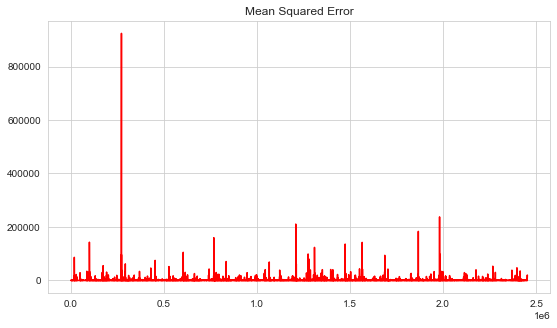

In [11]:
pd.Series(losses).plot(figsize=(9,5), c='r');
plt.title('Mean Squared Error');
plt.show()

# Reward

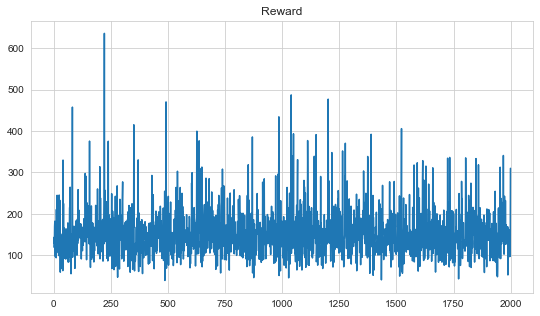

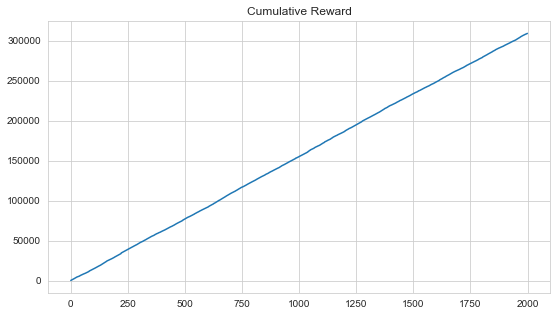

In [12]:
plt.figure(figsize=(9,5));
plt.plot(total_reward);
plt.title('Reward');
plt.show()
pd.Series(total_reward).cumsum().plot(figsize=(9,5));
plt.title('Cumulative Reward');

# Epsilon

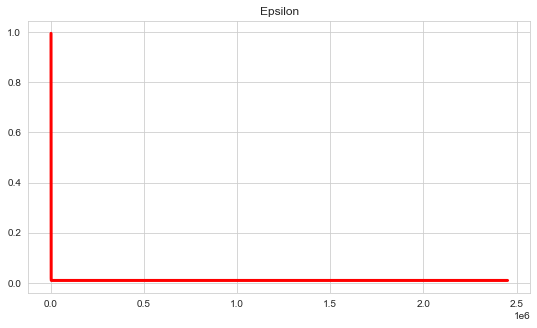

In [13]:
plt.figure(figsize=(9,5))
plt.plot(agent.save_epsilon, lw=3, c='r');plt.title('Epsilon');

# Validation

Loading complete!!
Testing Model



Start: 2018-01-02 00:00:00  End: 2020-12-31 00:00:00
Since: 756 days
Begin portfolio value:  1000.00
End portfolio value:     975.07
Return -2.49 %
Sell: 273 times, Buy: 233 times


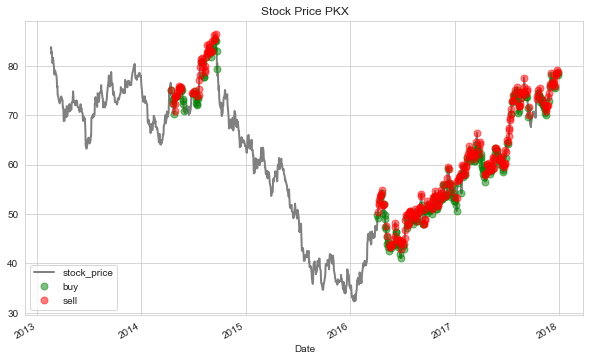

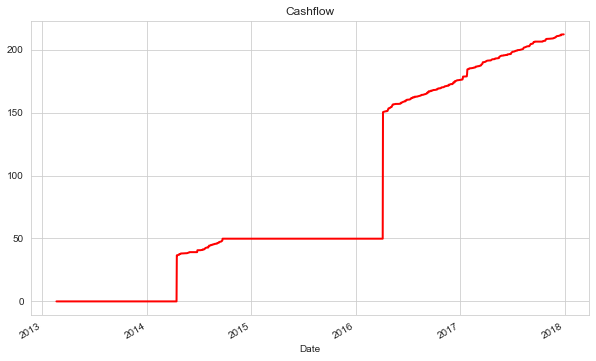

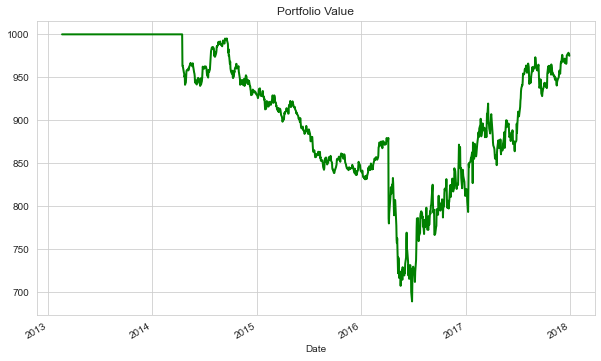

In [14]:
#validation 
capital = 1000
val_env = SingleStockEnv(train_data,
                             capital)
state_size = val_env.state_dim
nb_action = 2
agent = QAgent(state_size, nb_action, 0.9, ticker=stock_name)
with open(f'scaler/{stock_name}.pkl', 'rb') as f:
    scaler = pickle.load(f)


state = val_env.reset()
state = scaler.transform([state])
last_reward = 0
done = False
agent.load()
agent.epsilon = 0

while not done:
    action = agent.act(state)
    next_state, reward, done, info = val_env.step(action)
    next_state = scaler.transform([next_state])
    state = next_state


print('Testing Model')
print('=======================================================================')
print('=======================================================================')
print()
print()
print()
print(f'Start: {test_data.index[0]}  End: {test_data.index[-1]}')
print(f'Since: {len(test_data)} days')
print(f"Begin portfolio value: {capital:8.2f}")
print(f"End portfolio value: {info['portfolio_value'][-1]:10.2f}")
print(f"Return {(info['portfolio_value'][-1] - capital) * 100/capital:.2f} %")
print(f"Sell: {val_env.sell_buy.count('sell')} times, Buy: {val_env.sell_buy.count('buy')} times")
print('=======================================================================')

result = pd.DataFrame(info)
result.index = train_data.index

def marker_buy(col):
    price = col[0] 
    sellbuy = col[1]
    
    if sellbuy == 'buy':
        return price
    else:
        return np.nan
    
def marker_sell(col):
    price = col[0] 
    sellbuy = col[1]
    
    if sellbuy == 'sell':
        return price
    else:
        return np.nan
    
result['marker_buy'] = result[['stock_price', 'sell_buy']].apply(marker_buy, axis=1);
result['marker_sell'] = result[['stock_price', 'sell_buy']].apply(marker_sell, axis=1);

result['stock_price'].plot(figsize=(10,6), c='grey', lw='2');
result['marker_buy'].plot(style='o', ms=7, label='buy', c='g', alpha=0.5);
result['marker_sell'].plot(style='o', ms=7, label='sell', c='r', alpha=0.5);
plt.title('Stock Price '+ stock_name)
plt.legend();
plt.show()


result['cashflow'].plot(figsize=(10,6), c='r', lw=2);
plt.title('Cashflow');
plt.show()

result['portfolio_value'].plot(figsize=(10,6), c='g', lw=2);
plt.title('Portfolio Value');
plt.show()


# Testing

Loading complete!!
Testing Model



Start: 2018-01-02 00:00:00  End: 2020-12-31 00:00:00
Since: 756 days
Begin portfolio value:  1000.00
End portfolio value:     892.15
Return -10.79 %
Sell: 236 times, Buy: 232 times


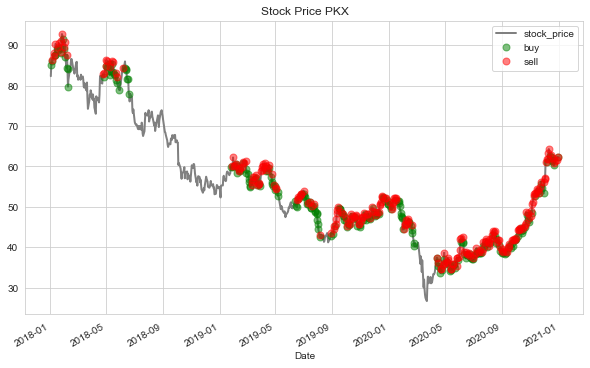

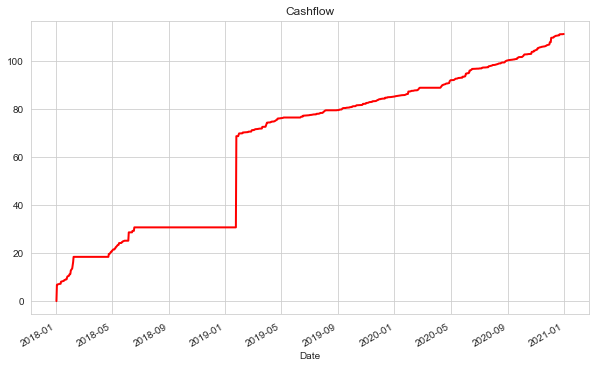

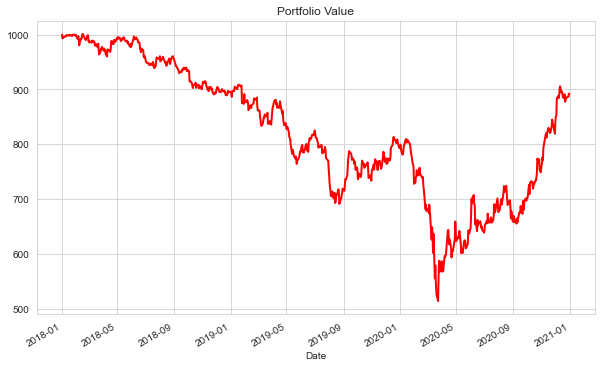

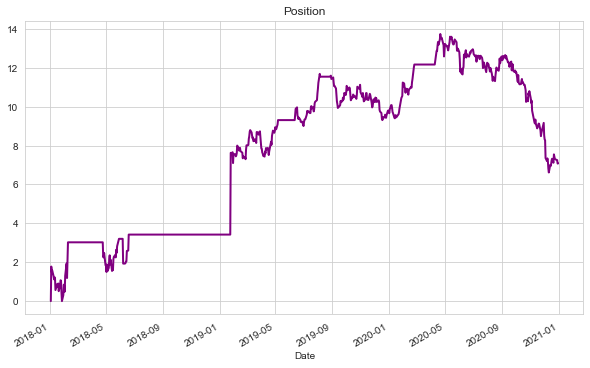

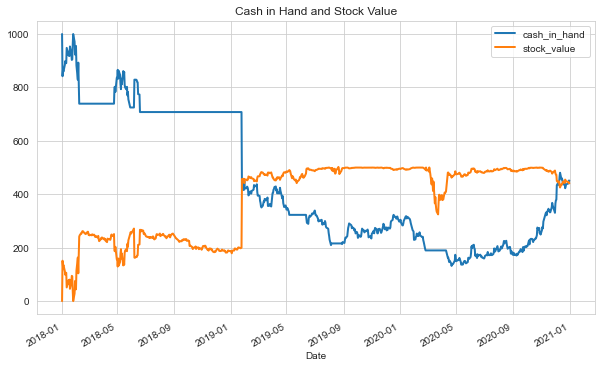

In [15]:
test_env = SingleStockEnv(test_data,
                             capital)
state_size = test_env.state_dim
nb_action = 2
agent = QAgent(state_size, nb_action, 0.9, ticker=stock_name)
with open(f'scaler/{stock_name}.pkl', 'rb') as f:
    scaler = pickle.load(f)


state = test_env.reset()
state = scaler.transform([state])
last_reward = 0
done = False
agent.load()
agent.epsilon = 0

while not done:
    action = agent.act(state)
    next_state, reward, done, info = test_env.step(action)
    next_state = scaler.transform([next_state])
    state = next_state


print('Testing Model')
print('=======================================================================')
print('=======================================================================')
print()
print()
print()
print(f'Start: {test_data.index[0]}  End: {test_data.index[-1]}')
print(f'Since: {len(test_data)} days')
print(f"Begin portfolio value: {capital:8.2f}")
print(f"End portfolio value: {info['portfolio_value'][-1]:10.2f}")
print(f"Return {(info['portfolio_value'][-1] - capital) * 100/capital:.2f} %")
print(f"Sell: {test_env.sell_buy.count('sell')} times, Buy: {test_env.sell_buy.count('buy')} times")
print('=======================================================================')

result = pd.DataFrame(info)
result.index = test_data.index

def marker_buy(col):
    price = col[0] 
    sellbuy = col[1]
    
    if sellbuy == 'buy':
        return price
    else:
        return np.nan
    
def marker_sell(col):
    price = col[0] 
    sellbuy = col[1]
    
    if sellbuy == 'sell':
        return price
    else:
        return np.nan
    
result['marker_buy'] = result[['stock_price', 'sell_buy']].apply(marker_buy, axis=1);
result['marker_sell'] = result[['stock_price', 'sell_buy']].apply(marker_sell, axis=1);

result['stock_price'].plot(figsize=(10,6), c='grey', lw=2);
result['marker_buy'].plot(style='o', ms=7, label='buy', c='g', alpha=0.5);
result['marker_sell'].plot(style='o', ms=7, label='sell', c='r', alpha=0.5);
plt.title('Stock Price '+ stock_name)
plt.legend();
plt.show()

result['cashflow'].plot(figsize=(10,6), c='r', lw=2);
plt.title('Cashflow');
plt.show()

result['portfolio_value'].plot(figsize=(10,6), c='r', lw=2);
plt.title('Portfolio Value');
plt.show()

result['stock_owned'].plot(figsize=(10,6), c='purple', lw=2);
plt.title('Position')
plt.show()

result[['cash_in_hand', 'stock_value']].plot(figsize=(10,6), lw=2);
plt.title('Cash in Hand and Stock Value');
plt.show()

# Performance Measurement - KPIs

In [47]:
import numpy as np
import datetime as dt

bn = web.DataReader('^GSPC', 'yahoo', '2018-01-01', '2021-01-01')
bn['Benchmark'] = bn['Adj Close']

def CAGR(DF):
    df = DF.copy()
    try:
        df['daily_ret'] = df['portfolio_value'].pct_change()
    except:
        df['daily_ret'] = df['Adj Close'].pct_change() 
    
    df['cumulative_ret'] = (1 + df['daily_ret']).cumprod()
    n = len(df)/252
    cagr = (df['cumulative_ret'][-1])**(1/n) - 1
    return cagr

def volatility(DF):
    df = DF.copy()
    try:
        df['daily_ret'] = df['portfolio_value'].pct_change()
    except:
        df['daily_ret'] = df['Adj Close'].pct_change() 
    vol = df['daily_ret'].std() * np.sqrt(252)
    return vol


def sharpe(DF, rf):
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr

def max_dd(DF):
    df = DF.copy()
    try:
        df['daily_ret'] = df['portfolio_value'].pct_change()
    except:
        df['daily_ret'] = df['Adj Close'].pct_change() 
    df['cumulative_ret'] = (1 + df['daily_ret']).cumprod()
    df['cum_roll_max'] = df['cumulative_ret'].cummax()
    df['drawdown'] = df['cum_roll_max'] - df['cumulative_ret']
    df['drawdown_pct'] = df['drawdown']/df['cum_roll_max']
    max_dd = df['drawdown_pct'].max()
    return max_dd

def calmer(DF):
    df = DF.copy()
    clmr = CAGR(df)/max_dd(df)
    return clmr



print(f'Stock name: {stock_name}')
print(f'Start: {result.index[0]}  End: {result.index[-1]}')
print(f'Compound Annual Growth Rate: {CAGR(result)*100:.2f} %')
print(f'Volatility: {volatility(result):.4f}')
print(f'shape ratio: {sharpe(result, 0.011):.4f}')
print(f'Maximun drawdown: {max_dd(result)*-100:.2f} %')
print(f'Calmar ratio: {calmer(result):.4f}')
print('-----------------------------------------------------------')
print('Comparing with Benchmark')
print(f'Compound Annual Growth Rate (benchmark): {CAGR(bn)*100:.2f} %')
print(f'Volatility (benchmark): {volatility(bn):.4f}')
print(f'shape ratio: {sharpe(bn, 0.011):.4f}')
print(f'Maximun drawdown: {max_dd(bn)*-100:.2f} %')
print(f'Calmar ratio (benchmark): {calmer(bn):.4f}')
print('-----------------------------------------------------------')
print('Comparing with Adj close')
print(f'Compound Annual Growth Rate (Adj close): {CAGR(test_data)*100:.2f} %')
print(f'Volatility (benchmark): {volatility(test_data):.4f}')
print(f'shape ratio: {sharpe(test_data, 0.011):.4f}')
print(f'Maximun drawdown: {max_dd(test_data)*-100:.2f} %')
print(f'Calmar ratio (benchmark): {calmer(test_data):.4f}')


Stock name: BBL
Start: 2018-01-02 00:00:00  End: 2020-12-31 00:00:00
Compound Annual Growth Rate: 8.69 %
Volatility: 0.1292
shape ratio: 0.5872
Maximun drawdown: -20.26 %
Calmar ratio: 0.4288
-----------------------------------------------------------
Comparing with Benchmark
Compound Annual Growth Rate (benchmark): 11.69 %
Volatility (benchmark): 0.2334
shape ratio: 0.4537
Maximun drawdown: -33.92 %
Calmar ratio (benchmark): 0.3446
-----------------------------------------------------------
Comparing with Adj close
Compound Annual Growth Rate (Adj close): 8.38 %
Volatility (benchmark): 0.3813
shape ratio: 0.1908
Maximun drawdown: -52.89 %
Calmar ratio (benchmark): 0.1584


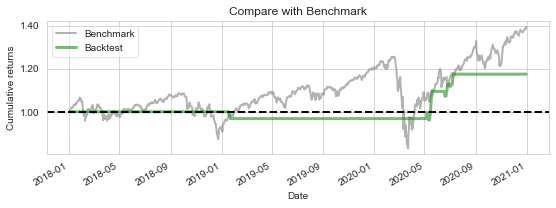

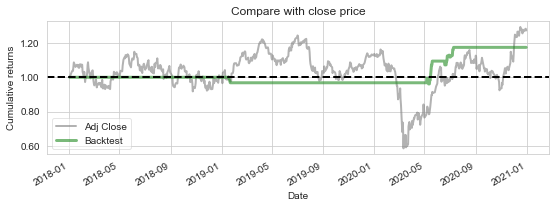

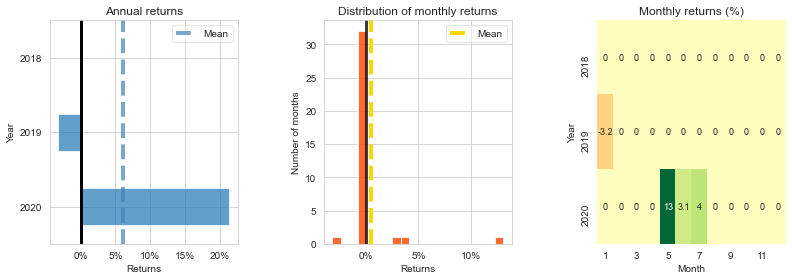

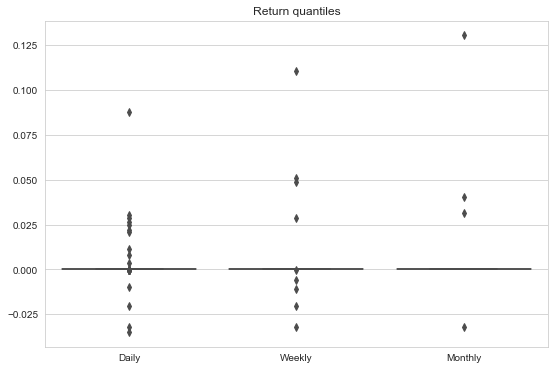

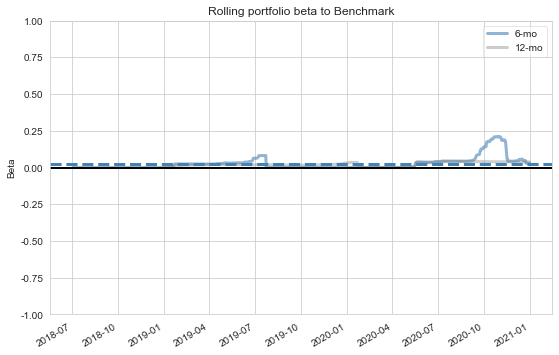

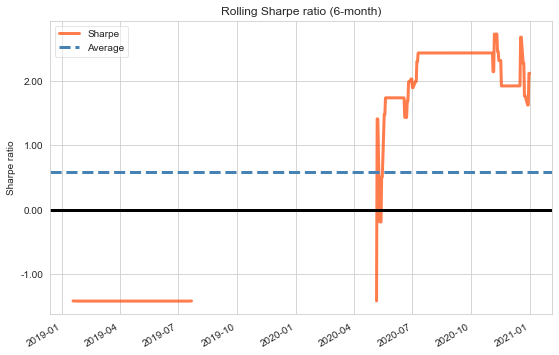

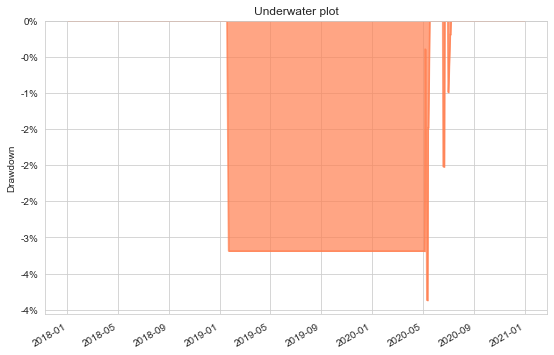

In [13]:
bt_returns = result['portfolio_value'].pct_change()
bm_returns = bn['Benchmark'].pct_change()
price = test_data['Adj Close'].pct_change()

plt.figure(figsize=(9,6));
plt.subplot(2,1,1);
pf.plotting.plot_rolling_returns(bt_returns, bm_returns);
plt.title('Compare with Benchmark');
plt.show()

plt.figure(figsize=(9,6));
plt.subplot(2,1,1);
pf.plotting.plot_rolling_returns(bt_returns, price);
plt.title('Compare with close price');
plt.show()

fig = plt.figure(1)
plt.subplot(1,3,1)
pf.plot_annual_returns(bt_returns)
plt.subplot(1,3,2)
pf.plot_monthly_returns_dist(bt_returns)
plt.subplot(1,3,3)
pf.plot_monthly_returns_heatmap(bt_returns)
plt.tight_layout()
fig.set_size_inches(12,4)

plt.figure(figsize=(9,6))
pf.plot_return_quantiles(bt_returns);

plt.figure(figsize=(9,6))
pf.plot_rolling_beta(bt_returns, bm_returns);

plt.figure(figsize=(9,6))
pf.plot_rolling_sharpe(bt_returns);

plt.figure(figsize=(9,6))
pf.plot_drawdown_underwater(bt_returns);